### Topic Modelling 

Overall Research Questions:
1) How do customers define 'good' service, and how does the new script shift those definitions?
2) What aspects of service (clarity, empathy, agent personality) drive variance in sentiment?
3) Does the new script systematically change perceptions or emotional tone, particularly for high-value segments like VOLT?

What are the best topic modelling approaches given the above?

In addition:
- What are the top latent topics mentioned?
- How do topic distributions differ by treatment?
- What percentage of comments mention agent personality, clarity, or reassurance?

Topic modelling is most relevant to RQ1, but relates to RQ3 as well.

#### Load the data/packages

In [ ]:

exec(open('../scripts/setup.py').read()) # load our data/packages
# Text preprocessing functions are already defined in the notebook

Main dataset loaded: (582, 16)


### Approach 1: Preprocessing + Topic Extraction (via BERTopic) - EXPERIMENTAL SECTION

**NOTE: This section contains experimental code that was not used in the final pipeline. The analysis showed that rule-based topic classification (Approach 2) was more suitable for the business questions. This code is preserved for reference and potential future development.**

Here we'll try a combination of pre processing steps to try to prepare the feedback text with the goal of extracting substantively meaningful topics with a BERTopic Model that would help answer our research questions.

**Why BERTopic?**

Through the use of transformers, it is robust to typos (a common trait we saw previously) and it provides a adaptive algorithm for finding semantic/definitional similarity between words. This is better than other topic modelling architectures (like LSA) that perform poorly on short documents and relies on term-document matrices that may become very sparse. LDA relies on word co-occurence patterns within documents so might also struggle with short texts. Since we ultimately want to predict sentiment with topics, we need the ability to extract on the short-texts.  

**After Experimentation: (added after doing the below)**

After the below steps, I've now seen that the preprocessing involved for the BERTopic model is quite involved, as the input drastically changes the topics extracted. Since the model is applying unsupervised measurement, it is quite sensitive to adjectives and certain stop-words that are often difficult to robustly filter in preprocessing. The topics extracted weren't very useful from a substantive perspective and would be defined as 'agent_everything_package_service' or 'explained_everything_well_fully'. While these are initially useful, I'm adding Approach 2 alongside Approach 1 to get more concrete topic extraction based on different categories, with methodology detailed in that section below.

In [230]:
df.head()

,GROUP,VOLT_FLAG,SURVEY_ID,SCORE,LTR_COMMENT,PRIMARY_REASON,MONTH,CONNECTION_TIME,SALES_PERSON_SAT,SALES_FRIENDLY_SAT,COMMINICATION_SAT,FIRST_BILL_SAT,AGENT_KNOWLEDGE,VOLT_FLAG_BINARY,TREATMENT_BINARY,LTR_COMMENT_CLEAN
45,control,NaN,352240580,10,Good package,NaN,2023-03-01,10,10,8,10,10,10,0,0,Good package
46,control,yes,351664275,10,Very good customer service,"Customer Service,General,UK Legacy",2023-03-01,10,10,10,10,10,10,1,0,Very good customer service
47,control,yes,351723391,10,So far so good. Charlie was very efficient and...,NaN,2023-03-01,10,<NA>,10,10,10,10,1,0,So far so good. Charlie was very efficient and...
48,control,NaN,351702901,10,Great communication,"Customer Service,General,UK Legacy",2023-03-01,9,10,10,10,10,10,0,0,Great communication
49,control,yes,352243612,10,Because Chris was amazing when she contacted m...,"Customer Service,UK Legacy",2023-03-01,10,<NA>,10,10,10,10,1,0,Because Chris was amazing when she contacted m...


#### Let's randomly sample some text responses to build a suitable approach

In [231]:
# randomly print a sample from non-missing LTR_COMMENT in df
sample_size = 20
sample = df[df['LTR_COMMENT'].notna()]['LTR_COMMENT'].sample(n=sample_size, random_state=46).tolist()
for i, comment in enumerate(sample, 1):
    print(f"Sample {i}: {comment}\n")

Sample 1: Very helpful staff

Sample 2: Very polite engineer who consulted every step and very patient

Sample 3: The experience is really good. The price can be a bit expensive. But I have had good experience with company media so far. The engineer, who came to my address was very professional and friendly. And did a really good job running the wires nice and tidy. Exactly how I wanted.

Sample 4: Good value reasonable prices

Sample 5: Very efficient and helpful

Sample 6: The lady I spoke to was very helpful.

Sample 7: Because it's too fast

Sample 8: Just felt treated better than with sky

Sample 9: Your customer service is awful and you really need to ditch the overseas call centers. Kindness and understanding in the voice go a long way. You can feel the contempt in operator voices (sniggering and laughing when you say you cannot understnd what they are saying - feels intentional) and cannot quite get all of the words due to very strong accents. Your only saving grace is the phys

Comments comprise long and short responses. Topic modelling is more nuanced for longer responses, even though short responses can reflect similar (but more simple) themes. THe model is highly sensitive to its inputs.

A suitable first step for preprocessing is to clean the responses to remove punctuation and unusual characters. We just want the words that convey meaningful information about the **topic** of the comment.

In [232]:
# Add the following as a module later on

import pandas as pd
import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

# Download required NLTK data
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)  
nltk.download('omw-1.4', quiet=True)

def clean_text(text, return_tokens=False, min_word_length=2, language='english'):
    """
    Clean a single text string for NLP analysis.
    
    Parameters:
    -----------
    text : str
        Input text string to clean
    return_tokens : bool, default False
        If True, returns list of tokens; if False, returns cleaned text string
    min_word_length : int, default 2
        Minimum word length to keep
    language : str, default 'english'
        Language for stopwords
    
    Returns:
    --------
    str or list
        Cleaned text string or list of tokens
    """
    # Initialize components
    stop_words = set(stopwords.words(language))
    lemmatizer = WordNetLemmatizer()
    
    # Handle missing/empty text
    if pd.isna(text) or not str(text).strip():
        return [] if return_tokens else ''
    
    # Convert to string and lowercase
    text = str(text).lower()
    
    # Remove punctuation and normalize whitespace
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Tokenize, filter stopwords and short words
    tokens = [word for word in text.split() 
              if word not in stop_words and len(word) >= min_word_length]
    
    # Lemmatize tokens
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    return tokens if return_tokens else ' '.join(tokens)

def clean_text_series(series, return_tokens=False, min_word_length=2, language='english'):
    """
    Apply text cleaning to a pandas Series.
    
    Parameters:
    -----------
    series : pandas.Series
        Series containing text data
    return_tokens : bool, default False
        If True, returns list of tokens; if False, returns cleaned text string
    min_word_length : int, default 2
        Minimum word length to keep
    language : str, default 'english'
        Language for stopwords
    
    Returns:
    --------
    pandas.Series
        Series with cleaned text
    """
    return series.apply(lambda x: clean_text(x, return_tokens, min_word_length, language))

def add_cleaned_text_columns(df, text_columns, suffix='_clean', 
                           min_word_length=2, language='english', 
                           add_tokens=True, add_word_count=True):
    """
    Add cleaned text columns to dataframe for multiple text columns.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input dataframe
    text_columns : str or list
        Column name(s) containing text to clean
    suffix : str, default '_clean'
        Suffix for cleaned text columns
    min_word_length : int, default 2
        Minimum word length to keep
    language : str, default 'english'
        Language for stopwords
    add_tokens : bool, default True
        Whether to add tokenized version
    add_word_count : bool, default True
        Whether to add word count column
        
    Returns:
    --------
    pandas.DataFrame
        Dataframe with additional cleaned text columns
    """
    df_result = df.copy()
    
    # Ensure text_columns is a list
    if isinstance(text_columns, str):
        text_columns = [text_columns]
    
    for col in text_columns:
        if col not in df.columns:
            continue
            
        # Add cleaned text column
        clean_col = f"{col}{suffix}"
        df_result[clean_col] = clean_text_series(
            df[col], return_tokens=False, 
            min_word_length=min_word_length, language=language
        )
        
        # Add tokenized version
        if add_tokens:
            tokens_col = f"{col}_tokens"
            df_result[tokens_col] = clean_text_series(
                df[col], return_tokens=True,
                min_word_length=min_word_length, language=language
            )
        
        # Add word count
        if add_word_count:
            count_col = f"{col}_word_count"
            df_result[count_col] = df_result[clean_col].str.split().str.len().fillna(0)
    
    return df_result

# Convenience function for common preprocessing pipeline
def preprocess_text_for_modeling(df, text_columns, min_word_length=2, 
                                language='english', filter_empty=True):
    """
    Complete preprocessing pipeline for text modeling.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input dataframe
    text_columns : str or list
        Column name(s) containing text to clean
    min_word_length : int, default 2
        Minimum word length to keep
    language : str, default 'english'
        Language for stopwords
    filter_empty : bool, default True
        Whether to add flag for non-empty text
        
    Returns:
    --------
    pandas.DataFrame
        Preprocessed dataframe ready for modeling
    """
    # Clean text
    df_clean = add_cleaned_text_columns(
        df, text_columns, min_word_length=min_word_length, 
        language=language, add_tokens=True, add_word_count=True
    )
    
    # Add flags for non-empty text
    if filter_empty:
        if isinstance(text_columns, str):
            text_columns = [text_columns]
        
        for col in text_columns:
            clean_col = f"{col}_clean"
            flag_col = f"has_{col}"
            df_clean[flag_col] = (df_clean[clean_col].str.len() > 0)
    
    return df_clean

In [233]:
df['LTR_COMMENT_CLEAN'] = clean_text_series(df['LTR_COMMENT'], return_tokens=False, min_word_length=2, language='english')

In [234]:
# Simple side-by-side comparison of original vs cleaned comments
sample_size = 10

# Get sample of non-missing comments
sample_df = df[df['LTR_COMMENT'].notna()].sample(n=sample_size, random_state=42)

print("=== ORIGINAL vs CLEANED COMMENTS ===\n")

for i, (idx, row) in enumerate(sample_df.iterrows(), 1):
    print(f"--- Sample {i} ---")
    print(f"ORIGINAL: {row['LTR_COMMENT']}")
    print(f"CLEANED:  {row['LTR_COMMENT_CLEAN']}")
    print("-" * 80)


=== ORIGINAL vs CLEANED COMMENTS ===

--- Sample 1 ---
ORIGINAL: Percy explained things clearly and understood from the start what I wanted. there was no hard sell. there was listening and understanding. top marks Percy and thank you
CLEANED:  percy explained thing clearly understood start wanted hard sell listening understanding top mark percy thank
--------------------------------------------------------------------------------
--- Sample 2 ---
ORIGINAL: Excellent service lovely representative Mathius
CLEANED:  excellent service lovely representative mathius
--------------------------------------------------------------------------------
--- Sample 3 ---
ORIGINAL: Very friendly staff and accommodating
CLEANED:  friendly staff accommodating
--------------------------------------------------------------------------------
--- Sample 4 ---
ORIGINAL: Very difficult to talk to anyone, very expensive, always an IT problem, too many calls, lots of mistakes took place with my name, dates leav

The above applies lammatization, removes standard stopwords and short words from a the natural language toolkit approach. 

We can see in the above that the topic is more distilled down in these cases. However, it is still not very clear. There are a number of remaining questions. What do we do with verbs? Do we just extract nouns? What about the adjectives related to the customer service provider?

All of the above examples are informed, but they aren't necessarily filtered enough to be very useful. We'll come back to this in approach 2.

Later on, we could also explore lemmatization and stemming, which would further enable generalizability between comments. However, BERTopic is generally pretty robust even without these steps, through its use of transformers that do pretty well at finding similar word meanings/connotations. 

For now, we'll proceed with BERTopic.

#### BERTopic Modelling

In [235]:
# BERTopic Implementation
import pandas as pd
import numpy as np
from bertopic import BERTopic

# Load your data (assuming df is already loaded with LTR_COMMENT_CLEAN column)
# df = pd.read_pickle('../data/processed/cleaned_call_script_data.pkl')

# Step 1: Data preparation - filter out null/missing comments
df_clean = (df
    .loc[df['LTR_COMMENT_CLEAN'].notna()]  # Remove missing comments
    .loc[df['LTR_COMMENT_CLEAN'].str.len() >= 20]  # Remove very short comments
    #.reset_index(drop=True)  # Reset index after filtering
    .copy()
)

print(f"Original data shape: {df.shape}")
print(f"Clean data shape: {df_clean.shape}")
print(f"Number of comments for topic modeling: {len(df_clean)}")


Original data shape: (582, 16)
Clean data shape: (349, 16)
Number of comments for topic modeling: 349


Note that we're removing very short comments less than 20 characters, since these rarely provide any novel topics besides simple sentiment.

In [236]:
# Step 2: Use the original text preprocessing approach defined earlier
# This uses the clean_text_series function with proper stopword removal and lemmatization

# Apply the original preprocessing to prepare documents for BERTopic
df_clean['text_processed'] = clean_text_series(
    df_clean['LTR_COMMENT'], 
    return_tokens=False, 
    min_word_length=2, 
    language='english'
)

# Filter out empty processed texts
df_clean = df_clean[df_clean['text_processed'].str.len() > 0].copy()

# Prepare final documents for topic modeling
docs = df_clean['text_processed'].tolist()

print(f"After preprocessing: {len(docs)} documents ready for topic modeling")

# Print comparison of original vs cleaned comments
print("\n=== ORIGINAL vs PREPROCESSED COMMENTS ===\n")
for i, (idx, row) in enumerate(df_clean.sample(n=10, random_state=42).iterrows(), 1):
    print(f"--- Sample {i} ---")
    print(f"ORIGINAL: {row['LTR_COMMENT']}")
    print(f"PREPROCESSED: {row['text_processed']}")
    print("-" * 80)

After preprocessing: 349 documents ready for topic modeling

=== ORIGINAL vs PREPROCESSED COMMENTS ===

--- Sample 1 ---
ORIGINAL: Agent was very helpful from start to finish and made sure we got the right package for us at the best price.
PREPROCESSED: agent helpful start finish made sure got right package u best price
--------------------------------------------------------------------------------
--- Sample 2 ---
ORIGINAL: Quick and efficient and good coverage
PREPROCESSED: quick efficient good coverage
--------------------------------------------------------------------------------
--- Sample 3 ---
ORIGINAL: The person on the phone was polite and gave me all the information I needed to make the right choice of which broadband was the best one for me
PREPROCESSED: person phone polite gave information needed make right choice broadband best one
--------------------------------------------------------------------------------
--- Sample 4 ---
ORIGINAL: Very polite & extremely helpful ,

In [237]:
# Step 3: Initialize BERTopic model
# BERT embeddings and clustering
topic_model = BERTopic(
    verbose=True,
    calculate_probabilities=True,  # Enable probability calculation
    nr_topics='auto'  # Let BERTopic determine optimal number of topics
)

In [238]:

# Step 4: Fit the model and get topics
print("Fitting BERTopic model...")
topics, probs = topic_model.fit_transform(docs)

# Step 5: Add results back to dataframe
df_clean = (df_clean
    .assign(
        topic=topics,
        topic_prob=probs.max(axis=1) if hasattr(probs, 'max') else [max(p) for p in probs]
    )
)


2025-08-06 10:48:52,191 - BERTopic - Embedding - Transforming documents to embeddings.


Fitting BERTopic model...


Batches:   0%|          | 0/11 [00:00<?, ?it/s]

2025-08-06 10:48:54,313 - BERTopic - Embedding - Completed ✓
2025-08-06 10:48:54,314 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-08-06 10:48:54,437 - BERTopic - Dimensionality - Completed ✓
2025-08-06 10:48:54,438 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-08-06 10:48:54,455 - BERTopic - Cluster - Completed ✓
2025-08-06 10:48:54,455 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-08-06 10:48:54,470 - BERTopic - Representation - Completed ✓
2025-08-06 10:48:54,470 - BERTopic - Topic reduction - Reducing number of topics
2025-08-06 10:48:54,474 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-08-06 10:48:54,484 - BERTopic - Representation - Completed ✓
2025-08-06 10:48:54,484 - BERTopic - Topic reduction - Reduced number of topics from 9 to 9


In [239]:

# Step 6: Display topic information
print(f"\nNumber of topics generated: {len(topic_model.get_topic_info())}")
print("\nTopic Information:")
topic_info = topic_model.get_topic_info()
print(topic_info.head(10))



Number of topics generated: 9

Topic Information:
   Topic  Count                                       Name                                     Representation                                Representative_Docs
0     -1    116             -1_service_helpful_good_polite  [service, helpful, good, polite, friendly, com...  [called join new customer moving new property ...
1      0     76                 0_company_would_call_phone  [company, would, call, phone, broadband, day, ...  [agent set account said would give u 150 free ...
2      1     43         1_customer_service_excellent_great  [customer, service, excellent, great, good, pr...  [good customer service, good customer service,...
3      2     33          2_helpful_explained_friendly_help  [helpful, explained, friendly, help, everythin...  [friendly explained thing well, helpful explai...
4      3     21  3_engineer_professional_hedge_obstruction  [engineer, professional, hedge, obstruction, j...  [experience really good price bit

In [240]:

# Step 7: Show representative documents for each topic
print("\nSample documents by topic:")
for topic_id in topic_info['Topic'][:5]:  # Show first 5 topics
    if topic_id != -1:  # Skip outlier topic
        print(f"\n--- Topic {topic_id} ---")
        sample_docs = df_clean[df_clean['topic'] == topic_id]['LTR_COMMENT_CLEAN'].head(3)
        for i, doc in enumerate(sample_docs, 1):
            print(f"{i}. {doc[:100]}...")



Sample documents by topic:

--- Topic 0 ---
1. phone helpful fella question got running little time better internet around area...
2. set yet speaking ashley informative pleasant saturday chap came day road house infrastructure satisf...
3. higher speed sky connection disappointed connected 3x tv tablet mobile phone via wifi rubbish signal...

--- Topic 1 ---
1. good customer service...
2. amazing service job completed...
3. hood customer service...

--- Topic 2 ---
1. far good charlie efficient helpful let hope continues confident...
2. friendly easy talk understood wanted happy help...
3. explained could understand said thank lady spoke...

--- Topic 3 ---
1. extremely helpful engineer visit jo 32725...
2. mat brilliant followed advailabe really professional plesent deal...
3. professional service...


In [241]:

# Step 8: Topic reduction (if needed)
# print(f"\nOriginal number of topics: {len(topic_model.get_topic_info())}")

# # Reduce topics if there are too many (following guide's example)
# if len(topic_model.get_topic_info()) > 20:
#     print("Reducing number of topics...")
#     topic_model.reduce_topics(docs, nr_topics=15)
    
#     # Update topics after reduction
#     topics_reduced = topic_model.topics_
#     df_clean['topic_reduced'] = topics_reduced
    
#     print(f"Reduced number of topics: {len(topic_model.get_topic_info())}")


**Some rough notes, keeping for documentation**

Some things to consider:

- We can remove all sentiment related words, does this improve concrete topic extraction?
- Substantively, should our topics include sentiment related words? What's a justifiable methodology for our three questions?

Should dedicate an entire section to outlining the methodology surrounding stop words. At times, adjectives are useful. And at times, they aren't.

- It may be possible to do a continuous classification, rather than a discrete classification of each comment into every category. And then apply a threshold based on cosine similarity etc.

Need to look into fine-tuning the BERTopic model or using a different approach, current topics just aren't substantively relevant at the moment. Need to fine-tune based on addressing the specific segmentation questions.

Add an LLM-based implementation? May be more adaptive to the nuances of our data.

Should also look into entity analysis, which can extract the proper nouns and things within each response, and then pass these onto the topic/theme model. [text](https://cloud.google.com/natural-language/docs/analyzing-entities)

### Approach 2: Entity Extraction, Categorical Preprocessing and Filtered Topic Modelling

The problem with approach 1, is that while sometimes useful, the topics are too generic. What does helpful_friendly_explained_everything actually mean? They all just boil down to good customer service. 

We're really interested in questions like:
- are competitors mentioned?
- do they refer to the customer service staff?
- do they refer to timeliness? (being on hold?)
- do they refer to contact patterns (getting callbacks etc.)?

A better approach is to extract out topics based on certain areas: adjectives, nouns, and perhaps verbs separately. Then rerun our topic analysis.

Nouns are most useful for our areas of interest. We'll try that first.  

#### Noun Extraction with Spacy NLP Model

In [242]:
# Noun Extraction using spaCy (more reliable than NLTK for POS tagging)
import pandas as pd
from collections import Counter
import nltk
import spacy
spacy.load('en_core_web_sm')


# Install spaCy if not already installed
# Run this in terminal: pip install spacy
# Then download English model: python -m spacy download en_core_web_sm

try:
    import spacy
    # Load the English language model
    nlp = spacy.load("en_core_web_sm")
    print("spaCy loaded successfully")
    spacy_available = True
except ImportError:
    print("spaCy not installed. Please run:")
    print("pip install spacy")
    print("python -m spacy download en_core_web_sm")
    spacy_available = False
except OSError:
    print("spaCy English model not found. Please run:")
    print("python -m spacy download en_core_web_sm")
    spacy_available = False

def extract_nouns_with_spacy(text_content: str):
    """
    Extract nouns using spaCy's advanced POS tagging.
    Returns both common nouns and proper nouns.
    """
    if pd.isna(text_content) or not text_content.strip() or not spacy_available:
        return {'common_nouns': [], 'proper_nouns': [], 'all_nouns': []}
    
    try:
        # Process the text with spaCy
        doc = nlp(text_content)
        
        common_nouns = []
        proper_nouns = []
        
        for token in doc:
            # Skip punctuation, spaces, and very short words
            if token.is_punct or token.is_space or len(token.text) < 3:
                continue
                
            # Extract different types of nouns
            if token.pos_ == 'NOUN':  # Common nouns
                common_nouns.append(token.lemma_.lower())
            elif token.pos_ == 'PROPN':  # Proper nouns
                proper_nouns.append(token.text.lower())
        
        # Remove common stopwords that might slip through
        stop_words = {'thing', 'time', 'way', 'day', 'people', 'lot', 'bit'}
        common_nouns = [noun for noun in common_nouns if noun not in stop_words]
        proper_nouns = [noun for noun in proper_nouns if noun not in stop_words]
        
        # Combine all nouns
        all_nouns = list(set(common_nouns + proper_nouns))
        
        return {
            'common_nouns': common_nouns,
            'proper_nouns': proper_nouns,
            'all_nouns': all_nouns
        }
        
    except Exception as e:
        print(f"Error processing text with spaCy: {str(e)[:100]}...")
        return {'common_nouns': [], 'proper_nouns': [], 'all_nouns': []}

# Fallback function using NLTK if spaCy is not available
def extract_nouns_with_nltk_fallback(text_content: str):
    """
    Fallback noun extraction using NLTK if spaCy is not available.
    """
    if pd.isna(text_content) or not text_content.strip():
        return {'common_nouns': [], 'proper_nouns': [], 'all_nouns': []}
    
    try:
        import nltk
        from nltk import word_tokenize, pos_tag
        
        # Ensure required NLTK data is downloaded
        nltk.download('punkt', quiet=True)
        nltk.download('averaged_perceptron_tagger', quiet=True)
        
        # Tokenize and tag parts of speech
        tokens = word_tokenize(text_content)
        pos_tags = pos_tag(tokens)
        
        common_nouns = []
        proper_nouns = []
        
        for word, pos in pos_tags:
            if len(word) < 3 or not word.isalpha():
                continue
                
            if pos in ['NN', 'NNS']:  # Common nouns
                common_nouns.append(word.lower())
            elif pos in ['NNP', 'NNPS']:  # Proper nouns
                proper_nouns.append(word.lower())
        
        # Remove common stopwords
        stop_words = {'the', 'and', 'for', 'are', 'but', 'not', 'you', 'all', 'can', 'had', 'her', 'was', 'one', 'our', 'out', 'day', 'get', 'has', 'him', 'his', 'how', 'its', 'may', 'new', 'now', 'old', 'see', 'two', 'who', 'boy', 'did', 'man', 'way', 'bit', 'lot', 'time', 'thing', 'people'}
        common_nouns = [noun for noun in common_nouns if noun not in stop_words]
        proper_nouns = [noun for noun in proper_nouns if noun not in stop_words]
        
        all_nouns = list(set(common_nouns + proper_nouns))
        
        return {
            'common_nouns': common_nouns,
            'proper_nouns': proper_nouns,
            'all_nouns': all_nouns
        }
        
    except Exception as e:
        print(f"Error in NLTK processing: {e}")
        return {'common_nouns': [], 'proper_nouns': [], 'all_nouns': []}

def extract_nouns_from_text(text_content: str):
    """
    Main function to extract nouns. Uses spaCy if available, otherwise NLTK.
    """
    if spacy_available:
        return extract_nouns_with_spacy(text_content)
    else:
        return extract_nouns_with_nltk_fallback(text_content)

# Apply noun extraction to a sample of comments
print("Extracting nouns from customer comments...")
print("Using ORIGINAL text (not preprocessed) for better noun recognition")

if spacy_available:
    print("Using spaCy for advanced POS tagging")
else:
    print("Using NLTK fallback for POS tagging")

# Take a sample for testing
sample_size = 10
sample_df = df_clean.sample(n=sample_size, random_state=42).copy()

# Extract nouns using ORIGINAL text
noun_results = []
for idx, row in sample_df.iterrows():
    print(f"Processing comment {len(noun_results) + 1}/{sample_size}...")
    # Use original text for noun extraction, not preprocessed
    result = extract_nouns_from_text(row['LTR_COMMENT'])
    result['index'] = idx
    noun_results.append(result)

# Add results back to sample dataframe
sample_df['common_nouns'] = [result['common_nouns'] for result in noun_results]
sample_df['proper_nouns'] = [result['proper_nouns'] for result in noun_results]
sample_df['all_nouns'] = [result['all_nouns'] for result in noun_results]

# Display results with comparison
print("\n=== NOUN EXTRACTION RESULTS ===\n")

for i, (idx, row) in enumerate(sample_df.iterrows(), 1):
    print(f"--- Sample {i} ---")
    print(f"ORIGINAL: {row['LTR_COMMENT']}")
    print(f"PREPROCESSED: {row['text_processed']}")
    print(f"COMMON NOUNS: {row['common_nouns']}")
    print(f"PROPER NOUNS: {row['proper_nouns']}")
    print(f"ALL NOUNS: {row['all_nouns']}")
    print("-" * 80)

# Summary statistics
print(f"\n=== SUMMARY STATISTICS ===")
print(f"Total samples processed: {len(sample_df)}")
print(f"Samples with common nouns: {sum(len(nouns) > 0 for nouns in sample_df['common_nouns'])}")
print(f"Samples with proper nouns: {sum(len(nouns) > 0 for nouns in sample_df['proper_nouns'])}")
print(f"Samples with any nouns: {sum(len(nouns) > 0 for nouns in sample_df['all_nouns'])}")

# Most common nouns across all categories
all_common_nouns = [noun for nouns_list in sample_df['common_nouns'] for noun in nouns_list]
all_proper_nouns = [noun for nouns_list in sample_df['proper_nouns'] for noun in nouns_list]
all_nouns_combined = [noun for nouns_list in sample_df['all_nouns'] for noun in nouns_list]

if all_common_nouns:
    common_noun_counts = Counter(all_common_nouns)
    print(f"Most common nouns: {common_noun_counts.most_common(10)}")

if all_proper_nouns:
    proper_noun_counts = Counter(all_proper_nouns)
    print(f"Most common proper nouns: {proper_noun_counts.most_common(5)}")

if all_nouns_combined:
    all_noun_counts = Counter(all_nouns_combined)
    print(f"Most frequent nouns overall: {all_noun_counts.most_common(15)}")

print(f"\nMethod used: {'spaCy' if spacy_available else 'NLTK fallback'}")

spaCy loaded successfully
Extracting nouns from customer comments...
Using ORIGINAL text (not preprocessed) for better noun recognition
Using spaCy for advanced POS tagging
Processing comment 1/10...
Processing comment 2/10...
Processing comment 3/10...
Processing comment 4/10...
Processing comment 5/10...
Processing comment 6/10...
Processing comment 7/10...
Processing comment 8/10...
Processing comment 9/10...
Processing comment 10/10...

=== NOUN EXTRACTION RESULTS ===

--- Sample 1 ---
ORIGINAL: Agent was very helpful from start to finish and made sure we got the right package for us at the best price.
PREPROCESSED: agent helpful start finish made sure got right package u best price
COMMON NOUNS: ['start', 'package', 'price']
PROPER NOUNS: ['agent']
ALL NOUNS: ['agent', 'package', 'price', 'start']
--------------------------------------------------------------------------------
--- Sample 2 ---
ORIGINAL: Quick and efficient and good coverage
PREPROCESSED: quick efficient good cover

In [243]:
# Apply noun extraction to the full dataset and run BERTopic on common nouns
print("=== APPLYING NOUN EXTRACTION TO FULL DATASET ===")

# Extract nouns from all comments in the dataset
print("Extracting nouns from all comments in the dataset...")
print(f"Processing {len(df_clean)} comments...")

# Note: We extract nouns from ORIGINAL text, not preprocessed text
# This preserves proper nouns and context for better POS tagging
all_noun_results = []
for idx, row in df_clean.iterrows():
    if idx % 100 == 0:  # Progress indicator
        print(f"Processed {idx}/{len(df_clean)} comments...")
    
    # Extract nouns from ORIGINAL text (not preprocessed)
    result = extract_nouns_from_text(row['LTR_COMMENT'])
    all_noun_results.append(result)

# Add noun extraction results to the full dataframe
df_clean['common_nouns'] = [result['common_nouns'] for result in all_noun_results]
df_clean['proper_nouns'] = [result['proper_nouns'] for result in all_noun_results]
df_clean['all_nouns'] = [result['all_nouns'] for result in all_noun_results]

print(f"Noun extraction complete for {len(df_clean)} comments")

# Create documents from common nouns for BERTopic
# Join common nouns with spaces to create noun-only documents
noun_docs = []
for nouns_list in df_clean['common_nouns']:
    if nouns_list:  # Only include if there are nouns
        noun_docs.append(' '.join(nouns_list))
    else:
        noun_docs.append('')  # Empty string for comments with no nouns

# Filter out empty noun documents
non_empty_indices = [i for i, doc in enumerate(noun_docs) if doc.strip()]
filtered_noun_docs = [noun_docs[i] for i in non_empty_indices]
filtered_df = df_clean.iloc[non_empty_indices].copy()

print(f"Created {len(filtered_noun_docs)} noun-only documents for topic modeling")
print(f"Filtered out {len(df_clean) - len(filtered_noun_docs)} comments with no extractable nouns")

# Sample of noun-only documents
print("\n=== SAMPLE NOUN-ONLY DOCUMENTS ===")
for i, doc in enumerate(filtered_noun_docs[:10]):
    original_comment = filtered_df.iloc[i]['LTR_COMMENT']
    print(f"--- Sample {i+1} ---")
    print(f"ORIGINAL: {original_comment}")
    print(f"NOUN-ONLY: {doc}")
    print("-" * 60)

# Initialize BERTopic model for noun-based topic modeling
print("\n=== RUNNING BERTOPIC ON NOUN-ONLY DOCUMENTS ===")
noun_topic_model = BERTopic(
    verbose=True,
    calculate_probabilities=True,
    nr_topics='auto'  # Let BERTopic determine optimal number of topics
)

# Fit the model on noun-only documents
print("Fitting BERTopic model on noun-only documents...")
noun_topics, noun_probs = noun_topic_model.fit_transform(filtered_noun_docs)

# Add results back to filtered dataframe
filtered_df = filtered_df.assign(
    noun_topic=noun_topics,
    noun_topic_prob=noun_probs.max(axis=1) if hasattr(noun_probs, 'max') else [max(p) for p in noun_probs]
)

# Display topic information
print(f"\nNumber of noun-based topics generated: {len(noun_topic_model.get_topic_info())}")
print("\nNoun-based Topic Information:")
noun_topic_info = noun_topic_model.get_topic_info()
print(noun_topic_info.head(10))

# Show representative documents for each topic
print("\nSample documents by noun-based topic:")
for topic_id in noun_topic_info['Topic'][:5]:  # Show first 5 topics
    if topic_id != -1:  # Skip outlier topic
        print(f"\n--- Noun Topic {topic_id} ---")
        # Show both original comments and noun-only versions
        topic_samples = filtered_df[filtered_df['noun_topic'] == topic_id].head(3)
        for i, (idx, row) in enumerate(topic_samples.iterrows(), 1):
            print(f"{i}. ORIGINAL: {row['LTR_COMMENT'][:80]}...")
            print(f"   NOUNS: {' '.join(row['common_nouns'])}")

# Summary statistics
print(f"\n=== NOUN-BASED TOPIC MODELING SUMMARY ===")
print(f"Total comments processed: {len(df_clean)}")
print(f"Comments with extractable nouns: {len(filtered_df)}")
print(f"Percentage with nouns: {len(filtered_df)/len(df_clean)*100:.1f}%")
print(f"Number of topics discovered: {len(noun_topic_info) - 1}")  # Exclude outlier topic

# Most common nouns overall
all_common_nouns_full = [noun for nouns_list in df_clean['common_nouns'] for noun in nouns_list]
if all_common_nouns_full:
    common_noun_counts_full = Counter(all_common_nouns_full)
    print(f"\nMost common nouns across all comments: {common_noun_counts_full.most_common(20)}")

=== APPLYING NOUN EXTRACTION TO FULL DATASET ===
Extracting nouns from all comments in the dataset...
Processing 349 comments...
Processed 100/349 comments...
Processed 200/349 comments...
Processed 300/349 comments...
Processed 500/349 comments...


2025-08-06 10:48:57,237 - BERTopic - Embedding - Transforming documents to embeddings.


Noun extraction complete for 349 comments
Created 322 noun-only documents for topic modeling
Filtered out 27 comments with no extractable nouns

=== SAMPLE NOUN-ONLY DOCUMENTS ===
--- Sample 1 ---
ORIGINAL: Very good customer service
NOUN-ONLY: customer service
------------------------------------------------------------
--- Sample 2 ---
ORIGINAL: Because Chris was amazing when she contacted me after I had put my details online.
NOUN-ONLY: detail
------------------------------------------------------------
--- Sample 3 ---
ORIGINAL: Price of my bundle went up 2 days after i placed the order
NOUN-ONLY: price bundle order
------------------------------------------------------------
--- Sample 4 ---
ORIGINAL: Simple and straightforward process but a lot of information and things to remember over the phone.
NOUN-ONLY: process information phone
------------------------------------------------------------
--- Sample 5 ---
ORIGINAL: Amazing service and job completed
NOUN-ONLY: service job
---

Batches:   0%|          | 0/11 [00:00<?, ?it/s]

2025-08-06 10:48:59,008 - BERTopic - Embedding - Completed ✓
2025-08-06 10:48:59,009 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-08-06 10:48:59,128 - BERTopic - Dimensionality - Completed ✓
2025-08-06 10:48:59,129 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-08-06 10:48:59,143 - BERTopic - Cluster - Completed ✓
2025-08-06 10:48:59,144 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-08-06 10:48:59,152 - BERTopic - Representation - Completed ✓
2025-08-06 10:48:59,153 - BERTopic - Topic reduction - Reducing number of topics
2025-08-06 10:48:59,156 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-08-06 10:48:59,162 - BERTopic - Representation - Completed ✓
2025-08-06 10:48:59,163 - BERTopic - Topic reduction - Reduced number of topics from 9 to 9



Number of noun-based topics generated: 9

Noun-based Topic Information:
   Topic  Count                                   Name                                     Representation                                Representative_Docs
0     -1    105            -1_company_medium_agent_sky  [company, medium, agent, sky, call, experience...  [phone company medium behalf cousin broadband ...
1      0     58     0_company_broadband_phone_property  [company, broadband, phone, property, internet...  [router whole house computer house phone hub r...
2      1     40         1_customer_service_fraud_email  [customer, service, fraud, email, company, hel...  [customer service, customer service, customer ...
3      2     28           2_staff_process_call_handler  [staff, process, call, handler, item, phone, d...   [service staff, call staff, process staff phone]
4      3     23  3_installation_engineer_contact_order  [installation, engineer, contact, order, 3rd, ...  [installation engineer team, agent 

We're getting somewhere, these seem more useful than before. However even with noun extraction, our topics still feel too generic. Also, does this really get into the granularity of the data?

### Approach 3: Creating Domain-Specific Topic Categories and BERT Finetuning

Instead of purely unsupervised topic modelling, let's implement a hybrid approach that targets our research questions.

This uses a keyword encoding scheme to assign points to informed categories from our qualitative analysis and assigns the category with the highest points. It utilizes a threshold so not every comment is automatically classified. 

After significant experimentation and testing. This involved seeing what transformation of specific words create meaningful and useful categorizations for our RQs without generating 1) too many categories with no observations or 2) too few generic categories that don't tell us anything useful. We end up with the following coding scheme.

In [244]:
# COMPLETELY REPLACE the categorize_service_aspects_final function with this:

def categorize_service_aspects_final(nouns, comment_text, min_threshold=2):
    """
    Final optimized categorization with consolidated categories - ONLY 7 CATEGORIES
    """
    aspect_keywords = {
        # === HUMAN INTERACTION (RQ1 & RQ2) ===
        'agent_personality': [
            # Positive traits
            'professional', 'friendly', 'knowledgeable', 'courteous', 'polite', 'helpful', 
            'patient', 'understanding', 'excellent', 'brilliant', 'fantastic', 'amazing', 
            'lovely', 'nice', 'kind', 'pleasant', 'competent', 'supportive', 'attentive',
            # Negative traits  
            'rude', 'unhelpful', 'impatient', 'arrogant', 'unprofessional', 'terrible', 
            'awful', 'useless', 'incompetent', 'annoying', 'frustrating', 'unfriendly', 
            'unapproachable', 'condescending', 'ignorant', 'abrupt', 'argumentative'
        ],
        
        # ADD BACK: Generic agent mentions (captures human element focus)
        'agent_mentions': [
            'agent', 'staff', 'representative', 'advisor', 'person', 'team', 'operator', 
            'consultant', 'employee', 'member', 'caller', 'handler', 'lady', 'gentleman', 
            'guy', 'worker', 'man', 'woman', 'individual', 'member of staff'
        ],
        
        # === COMMUNICATION & SUPPORT (RQ2 & RQ3) ===
        'communication_support': [
            # Communication quality (merge clarity + information provision)
            'explained', 'clear', 'clarified', 'detailed', 'thorough', 'understood', 'made sense',
            'simple', 'easy to follow', 'broke down', 'walked through', 'step by step',
            'confusing', 'unclear', 'vague', 'didn\'t understand', 'complicated', 'lost',
            'information', 'details', 'options', 'choices', 'alternatives', 'told', 'showed',
            'informed', 'outlined', 'went over', 'covered', 'discussed', 'presented'
        ],
        
        # ADD BACK: Specific clarity focus (RQ2 - script effectiveness)
        'clarity_communication': [
            'clear explanation', 'easy to understand', 'made it clear', 'clearly explained',
            'broke it down', 'step by step', 'walked me through', 'made sense', 'understood',
            'unclear', 'confusing', 'didn\'t explain clearly', 'hard to understand', 'vague'
        ],
        
        # ADD BACK: Specific support actions (captures concrete help)
        'support_actions': [
            'help', 'assistance', 'support', 'guidance', 'advice', 'sorted', 'resolved',
            'fixed', 'arranged', 'organized', 'handled', 'dealt with', 'took care',
            'sorted out', 'looked into', 'followed up', 'chased up', 'actioned'
        ],
        
        # === PROCESS EXPERIENCE (RQ3) ===
        'process_experience': [
            # Time efficiency (merge time_efficiency + time_problems)
            'quick', 'fast', 'prompt', 'speedy', 'efficient', 'straight away',
            'immediately', 'rapid', 'swift', 'instant', 'no time', 'right away',
            'waiting', 'hold', 'delay', 'slow', 'ages', 'forever', 'hung up',
            'long wait', 'hours', 'kept waiting', 'on hold', 'time wasted',
            # Process ease/friction
            'easy', 'straightforward', 'simple', 'smooth', 'seamless', 'hassle-free',
            'difficult', 'complicated', 'hassle', 'frustrating', 'problem', 'issue',
            'nightmare', 'ordeal', 'pain', 'struggle', 'mess', 'disaster'
        ],
        
        # === SERVICE CONTENT (Context - keep as-is) ===
        'technical_service': [
            'broadband', 'internet', 'wifi', 'connection', 'speed', 'installation', 
            'engineer', 'technical', 'router', 'modem', 'fiber', 'cable', 'network', 'signal'
        ],
        
        'financial_products': [  # Merge billing + packages
            'bill', 'price', 'cost', 'charge', 'payment', 'money', 'expensive', 'value',
            'package', 'deal', 'contract', 'plan', 'offer', 'upgrade', 'renewal', 'discount'
        ],
        
        'timeliness': [
            'waiting', 'hold', 'delay', 'slow', 'ages', 'forever', 'hung up',
            'long wait', 'hours', 'kept waiting', 'on hold', 'time wasted',
            'wait time', 'queue', 'holding', 'delayed'
        ],
        
        # === COMPETITIVE CONTEXT (RQ1) ===
        'competitive_retention': [  # Merge competitors + retention
            'sky', 'bt', 'virgin', 'talk talk', 'plusnet', 'competitor', 'switching',
            'stay', 'leave', 'cancel', 'better deal', 'match', 'compete', 'loyalty'
        ],
        
        # === CONTACT PATTERNS (Service Quality Indicator) ===
        'contact_patterns': [
            'callback', 'call back', 'promised', 'follow up', 'contact', 'ring',
            'again', 'second time', 'third call', 'repeatedly', 'still', 'another'
        ]
    }
    
    # Enhanced scoring logic
    aspect_scores = {}
    comment_lower = comment_text.lower()
    
    for aspect, keywords in aspect_keywords.items():
        score = 0
        
        # Noun matches (weight 2)
        for noun in nouns:
            for keyword in keywords:
                if keyword in noun.lower():
                    score += 2
                    break
        
        # Context matches with phrase bonuses
        for keyword in keywords:
            if keyword in comment_lower:
                if ' ' in keyword:
                    score += 2  # Multi-word phrases get extra weight
                else:
                    score += 1
        
        aspect_scores[aspect] = score
    
    # Apply threshold
    max_score = max(aspect_scores.values()) if aspect_scores.values() else 0
    
    if max_score < min_threshold:
        return aspect_scores, 'unclassified'
    else:
        primary_aspect = max(aspect_scores, key=aspect_scores.get)
        return aspect_scores, primary_aspect

# Re-run categorization - this should now give ONLY 7 categories + unclassified
print("=== CATEGORIZING WITH CONSOLIDATED CATEGORIES (FIXED) ===")
aspect_results = []
for idx, row in filtered_df.iterrows():
    scores, primary_aspect = categorize_service_aspects_final(row['common_nouns'], row['LTR_COMMENT'])
    aspect_results.append({'scores': scores, 'primary': primary_aspect})

# Extract primary aspects directly from function results
primary_aspects = [result['primary'] for result in aspect_results]

# Add to dataframe
filtered_df['primary_aspect_consolidated'] = primary_aspects

# Print categories defined in the function
print("=== CATEGORIES DEFINED IN FUNCTION ===")
sample_scores = aspect_results[0]['scores']
print("Available categories:", list(sample_scores.keys()))

# Print final value counts from the actual function results
print("\n=== FINAL PRIMARY ASPECT COUNTS (CONSOLIDATED) ===")
aspect_counts = pd.Series(primary_aspects).value_counts()
print(aspect_counts)

# Show percentage distribution
print("\n=== PERCENTAGE DISTRIBUTION ===")
aspect_percentages = pd.Series(primary_aspects).value_counts(normalize=True) * 100
for category, percentage in aspect_percentages.items():
    print(f"{category}: {percentage:.1f}%")
#%%

=== CATEGORIZING WITH CONSOLIDATED CATEGORIES (FIXED) ===
=== CATEGORIES DEFINED IN FUNCTION ===
Available categories: ['agent_personality', 'agent_mentions', 'communication_support', 'clarity_communication', 'support_actions', 'process_experience', 'technical_service', 'financial_products', 'timeliness', 'competitive_retention', 'contact_patterns']

=== FINAL PRIMARY ASPECT COUNTS (CONSOLIDATED) ===
agent_mentions           84
unclassified             66
technical_service        53
financial_products       38
process_experience       29
agent_personality        26
support_actions           9
contact_patterns          8
communication_support     5
competitive_retention     4
Name: count, dtype: int64

=== PERCENTAGE DISTRIBUTION ===
agent_mentions: 26.1%
unclassified: 20.5%
technical_service: 16.5%
financial_products: 11.8%
process_experience: 9.0%
agent_personality: 8.1%
support_actions: 2.8%
contact_patterns: 2.5%
communication_support: 1.6%
competitive_retention: 1.2%


In [245]:
# COMPLETELY REPLACE the categorize_service_aspects_final function with this:

def categorize_service_aspects_final(nouns, comment_text, min_threshold=2):
    """
    Final optimized categorization with consolidated categories - ONLY 7 CATEGORIES
    """
    aspect_keywords = {
        # === HUMAN INTERACTION (RQ1 & RQ2) ===
        'agent_personality': [
            # Positive traits
            'professional', 'friendly', 'knowledgeable', 'courteous', 'polite', 'helpful', 
            'patient', 'understanding', 'excellent', 'brilliant', 'fantastic', 'amazing', 
            'lovely', 'nice', 'kind', 'pleasant', 'competent', 'supportive', 'attentive',
            # Negative traits  
            'rude', 'unhelpful', 'impatient', 'arrogant', 'unprofessional', 'terrible', 
            'awful', 'useless', 'incompetent', 'annoying', 'frustrating', 'unfriendly', 
            'unapproachable', 'condescending', 'ignorant', 'abrupt', 'argumentative'
        ],
        
        # ADD BACK: Generic agent mentions (captures human element focus)
        'agent_mentions': [
            'agent', 'staff', 'representative', 'advisor', 'person', 'team', 'operator', 
            'consultant', 'employee', 'member', 'caller', 'handler', 'lady', 'gentleman', 
            'guy', 'worker', 'man', 'woman', 'individual', 'member of staff'
        ],
        
        # === COMMUNICATION & SUPPORT (RQ2 & RQ3) ===
        'communication_support': [
            # Communication quality (merge clarity + information provision)
            'explained', 'clear', 'clarified', 'detailed', 'thorough', 'understood', 'made sense',
            'simple', 'easy to follow', 'broke down', 'walked through', 'step by step',
            'confusing', 'unclear', 'vague', 'didn\'t understand', 'complicated', 'lost',
            'information', 'details', 'options', 'choices', 'alternatives', 'told', 'showed',
            'informed', 'outlined', 'went over', 'covered', 'discussed', 'presented'
        ],
        
        # ADD BACK: Specific clarity focus (RQ2 - script effectiveness)
        'clarity_communication': [
            'clear explanation', 'easy to understand', 'made it clear', 'clearly explained',
            'broke it down', 'step by step', 'walked me through', 'made sense', 'understood',
            'unclear', 'confusing', 'didn\'t explain clearly', 'hard to understand', 'vague'
        ],
        
        # ADD BACK: Specific support actions (captures concrete help)
        'support_actions': [
            'help', 'assistance', 'support', 'guidance', 'advice', 'sorted', 'resolved',
            'fixed', 'arranged', 'organized', 'handled', 'dealt with', 'took care',
            'sorted out', 'looked into', 'followed up', 'chased up', 'actioned'
        ],
        
        # === PROCESS EXPERIENCE (RQ3) ===
        'process_experience': [
            # Time efficiency (merge time_efficiency + time_problems)
            'quick', 'fast', 'prompt', 'speedy', 'efficient', 'straight away',
            'immediately', 'rapid', 'swift', 'instant', 'no time', 'right away',
            'waiting', 'hold', 'delay', 'slow', 'ages', 'forever', 'hung up',
            'long wait', 'hours', 'kept waiting', 'on hold', 'time wasted',
            # Process ease/friction
            'easy', 'straightforward', 'simple', 'smooth', 'seamless', 'hassle-free',
            'difficult', 'complicated', 'hassle', 'frustrating', 'problem', 'issue',
            'nightmare', 'ordeal', 'pain', 'struggle', 'mess', 'disaster'
        ],
        
        # === SERVICE CONTENT (Context - keep as-is) ===
        'technical_service': [
            'broadband', 'internet', 'wifi', 'connection', 'speed', 'installation', 
            'engineer', 'technical', 'router', 'modem', 'fiber', 'cable', 'network', 'signal'
        ],
        
        'financial_products': [  # Merge billing + packages
            'bill', 'price', 'cost', 'charge', 'payment', 'money', 'expensive', 'value',
            'package', 'deal', 'contract', 'plan', 'offer', 'upgrade', 'renewal', 'discount'
        ],
        
        'timeliness': [
            'waiting', 'hold', 'delay', 'slow', 'ages', 'forever', 'hung up',
            'long wait', 'hours', 'kept waiting', 'on hold', 'time wasted',
            'wait time', 'queue', 'holding', 'delayed'
        ],
        
        # === COMPETITIVE CONTEXT (RQ1) ===
        'competitive_retention': [  # Merge competitors + retention
            'sky', 'bt', 'virgin', 'talk talk', 'plusnet', 'competitor', 'switching',
            'stay', 'leave', 'cancel', 'better deal', 'match', 'compete', 'loyalty'
        ],
        
        # === CONTACT PATTERNS (Service Quality Indicator) ===
        'contact_patterns': [
            'callback', 'call back', 'promised', 'follow up', 'contact', 'ring',
            'again', 'second time', 'third call', 'repeatedly', 'still', 'another'
        ]
    }
    
    # Enhanced scoring logic
    aspect_scores = {}
    comment_lower = comment_text.lower()
    
    for aspect, keywords in aspect_keywords.items():
        score = 0
        
        # Noun matches (weight 2)
        for noun in nouns:
            for keyword in keywords:
                if keyword in noun.lower():
                    score += 2
                    break
        
        # Context matches with phrase bonuses
        for keyword in keywords:
            if keyword in comment_lower:
                if ' ' in keyword:
                    score += 2  # Multi-word phrases get extra weight
                else:
                    score += 1
        
        aspect_scores[aspect] = score
    
    # Apply threshold
    max_score = max(aspect_scores.values()) if aspect_scores.values() else 0
    
    if max_score < min_threshold:
        return aspect_scores, 'unclassified'
    else:
        primary_aspect = max(aspect_scores, key=aspect_scores.get)
        return aspect_scores, primary_aspect

# Re-run categorization - this should now give ONLY 7 categories + unclassified
print("=== CATEGORIZING WITH CONSOLIDATED CATEGORIES (FIXED) ===")
aspect_results = []
for idx, row in filtered_df.iterrows():
    scores, primary_aspect = categorize_service_aspects_final(row['common_nouns'], row['LTR_COMMENT'])
    aspect_results.append({'scores': scores, 'primary': primary_aspect})

# Extract primary aspects directly from function results
primary_aspects = [result['primary'] for result in aspect_results]

# Add to dataframe
filtered_df['primary_aspect_consolidated'] = primary_aspects

# Get all defined categories from the function
def get_all_categories():
    """Extract all category names from the function"""
    return [
        'agent_personality', 'agent_mentions', 'communication_support', 
        'clarity_communication', 'support_actions', 'process_experience',
        'technical_service', 'financial_products', 'timeliness', 
        'competitive_retention', 'contact_patterns'
    ]

all_categories = get_all_categories()

print("=== CATEGORIES DEFINED IN FUNCTION ===")
print("Available categories:", all_categories)
print("Total categories defined:", len(all_categories))

# Create a complete count including all categories (even those with 0 counts)
import pandas as pd
from collections import Counter

# Count actual assignments
actual_counts = Counter(primary_aspects)

# Create complete counts dictionary with all categories initialized to 0
complete_counts = {category: 0 for category in all_categories}
complete_counts['unclassified'] = 0  # Add unclassified as well

# Update with actual counts
for category, count in actual_counts.items():
    complete_counts[category] = count

print("\n=== COMPLETE PRIMARY ASPECT COUNTS (ALL CATEGORIES) ===")
# Sort by count (descending) then by name for ties
sorted_counts = sorted(complete_counts.items(), key=lambda x: (-x[1], x[0]))
for category, count in sorted_counts:
    print(f"{category}: {count}")

print(f"\nTotal comments processed: {len(primary_aspects)}")

# Show percentage distribution (only for categories with counts > 0)
print("\n=== PERCENTAGE DISTRIBUTION (NON-ZERO CATEGORIES) ===")
total_comments = len(primary_aspects)
for category, count in sorted_counts:
    if count > 0:
        percentage = (count / total_comments) * 100
        print(f"{category}: {count} ({percentage:.1f}%)")

# Summary of category usage
used_categories = sum(1 for count in complete_counts.values() if count > 0)
print(f"\n=== SUMMARY ===")
print(f"Categories with comments: {used_categories}")
print(f"Categories with zero comments: {len(complete_counts) - used_categories}")
print(f"Total categories defined: {len(complete_counts)}")

# ===== RAW SCORE ANALYSIS =====
print("\n" + "="*60)
print("=== RAW SCORE DISTRIBUTION ANALYSIS ===")
print("="*60)

# Extract all raw scores into a DataFrame for analysis
import pandas as pd
import numpy as np

# Create DataFrame with all scores for each comment
score_data = []
for i, result in enumerate(aspect_results):
    row = {'comment_id': i}
    row.update(result['scores'])
    score_data.append(row)

scores_df = pd.DataFrame(score_data)

# Remove comment_id column for calculations
score_columns = [col for col in scores_df.columns if col != 'comment_id']

print(f"\n=== TOTAL SCORES PER CATEGORY (Sum across all comments) ===")
total_scores = scores_df[score_columns].sum().sort_values(ascending=False)
for category, total_score in total_scores.items():
    print(f"{category}: {total_score}")

print(f"\n=== AVERAGE SCORES PER CATEGORY ===")
avg_scores = scores_df[score_columns].mean().sort_values(ascending=False)
for category, avg_score in avg_scores.items():
    print(f"{category}: {avg_score:.2f}")

print(f"\n=== COMMENTS WITH NON-ZERO SCORES PER CATEGORY ===")
nonzero_counts = (scores_df[score_columns] > 0).sum().sort_values(ascending=False)
for category, count in nonzero_counts.items():
    percentage = (count / len(scores_df)) * 100
    print(f"{category}: {count} comments ({percentage:.1f}%)")

print(f"\n=== SCORE DISTRIBUTION STATISTICS ===")
print("Category | Min | Max | Mean | Std | 75th | 90th | 95th")
print("-" * 60)
for category in score_columns:
    scores = scores_df[category]
    stats = {
        'min': scores.min(),
        'max': scores.max(), 
        'mean': scores.mean(),
        'std': scores.std(),
        'p75': scores.quantile(0.75),
        'p90': scores.quantile(0.90),
        'p95': scores.quantile(0.95)
    }
    print(f"{category[:15]:<15} | {stats['min']:3.0f} | {stats['max']:3.0f} | {stats['mean']:4.1f} | {stats['std']:4.1f} | {stats['p75']:4.1f} | {stats['p90']:4.1f} | {stats['p95']:4.1f}")

print(f"\n=== HIGH-SCORING COMMENTS (Score >= 5) ===")
for category in score_columns:
    high_score_comments = scores_df[scores_df[category] >= 5]
    if len(high_score_comments) > 0:
        print(f"\n{category}: {len(high_score_comments)} comments with score >= 5")
        print(f"  Max score: {scores_df[category].max()}")
        print(f"  Score distribution: {scores_df[category][scores_df[category] >= 5].value_counts().sort_index().to_dict()}")

print(f"\n=== MULTI-CATEGORY OVERLAP ANALYSIS ===")
# Find comments that score in multiple categories
scores_binary = (scores_df[score_columns] > 0).astype(int)
category_counts_per_comment = scores_binary.sum(axis=1)

print(f"Comments hitting multiple categories:")
overlap_counts = category_counts_per_comment.value_counts().sort_index()
for num_categories, num_comments in overlap_counts.items():
    percentage = (num_comments / len(scores_df)) * 100
    print(f"  {num_categories} categories: {num_comments} comments ({percentage:.1f}%)")

# Show most common category combinations for comments hitting multiple categories
print(f"\n=== MOST COMMON CATEGORY COMBINATIONS (for multi-category comments) ===")
multi_category_comments = scores_df[category_counts_per_comment > 1]
if len(multi_category_comments) > 0:
    # Create combination strings for comments with multiple categories
    combinations = []
    for idx, row in multi_category_comments.iterrows():
        active_categories = [cat for cat in score_columns if row[cat] > 0]
        if len(active_categories) > 1:
            combinations.append(" + ".join(sorted(active_categories)))
    
    if combinations:
        from collections import Counter
        combo_counts = Counter(combinations)
        print("Top 10 category combinations:")
        for combo, count in combo_counts.most_common(10):
            percentage = (count / len(combinations)) * 100
            print(f"  {combo}: {count} ({percentage:.1f}%)")

print(f"\n=== THRESHOLD SENSITIVITY ANALYSIS ===")
print("Threshold | Unclassified | Classified | % Classified")
print("-" * 50)
for threshold in [1, 2, 3, 4, 5]:
    unclassified_count = 0
    for result in aspect_results:
        max_score = max(result['scores'].values())
        if max_score < threshold:
            unclassified_count += 1
    
    classified_count = len(aspect_results) - unclassified_count
    classified_pct = (classified_count / len(aspect_results)) * 100
    print(f"    {threshold}     |     {unclassified_count}      |     {classified_count}     | {classified_pct:.1f}%")

=== CATEGORIZING WITH CONSOLIDATED CATEGORIES (FIXED) ===
=== CATEGORIES DEFINED IN FUNCTION ===
Available categories: ['agent_personality', 'agent_mentions', 'communication_support', 'clarity_communication', 'support_actions', 'process_experience', 'technical_service', 'financial_products', 'timeliness', 'competitive_retention', 'contact_patterns']
Total categories defined: 11

=== COMPLETE PRIMARY ASPECT COUNTS (ALL CATEGORIES) ===
agent_mentions: 84
unclassified: 66
technical_service: 53
financial_products: 38
process_experience: 29
agent_personality: 26
support_actions: 9
contact_patterns: 8
communication_support: 5
competitive_retention: 4
clarity_communication: 0
timeliness: 0

Total comments processed: 322

=== PERCENTAGE DISTRIBUTION (NON-ZERO CATEGORIES) ===
agent_mentions: 84 (26.1%)
unclassified: 66 (20.5%)
technical_service: 53 (16.5%)
financial_products: 38 (11.8%)
process_experience: 29 (9.0%)
agent_personality: 26 (8.1%)
support_actions: 9 (2.8%)
contact_patterns: 8 (2.5

### Approach 3: Combining the above 2 approaches in a Hybrid Approach, BERT Fine Tuning

We'll start with an rough initial approach, and then progress to finetuning

In [246]:
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from umap import UMAP
import hdbscan
import pandas as pd

# 1) Prepare your documents
docs_df = df_clean.dropna(subset=["LTR_COMMENT"])
docs    = docs_df["LTR_COMMENT"].tolist()
print(f"Fitting on {len(docs)} comments")

# 2) Your 7 seed‐topic keyword lists (as before)
category_seed_keywords = {
    "Agent Personality"     : ["professional","friendly","helpful","rude","unhelpful"],
    "Communication Support" : ["explained","clear","understood","confusing","outlined"],
    "Support Actions"       : ["help","support","resolved","assistance"],
    "Process Experience"    : ["quick","efficient","waiting","slow","easy","difficult"],
    "Service Content"       : ["broadband","internet","wifi","price","bill","package"],
    "Competitive Retention" : ["sky","bt","virgin","switching","cancel"],
    "Contact Patterns"      : ["callback","follow","again","second"]
}
seed_topic_list = list(category_seed_keywords.values())

# 3) Instantiate vectorizer, UMAP, **and** HDBSCAN _with_ prediction_data
vectorizer_model = CountVectorizer(stop_words="english")
umap_model       = UMAP(n_neighbors=15, min_dist=0.0, metric="cosine")
hdbscan_model    = hdbscan.HDBSCAN(
    min_cluster_size=10,
    metric="euclidean",
    cluster_selection_method="eom",
    prediction_data=True               # ← must have this for calculate_probabilities=True :contentReference[oaicite:0]{index=0}
)

# 4) Configure & fit BERTopic
topic_model = BERTopic(
    seed_topic_list       = seed_topic_list,
    vectorizer_model      = vectorizer_model,
    umap_model            = umap_model,
    hdbscan_model         = hdbscan_model,
    calculate_probabilities = True,    # now works without error
    verbose               = True
)
topics, probs = topic_model.fit_transform(docs)

# 5) Rename topics 0–6 to your human labels
auto_labels = topic_model.generate_topic_labels(nr_words=3)
custom_labels = [
    list(category_seed_keywords.keys())[i] if i < len(seed_topic_list) else lbl
    for i, lbl in enumerate(auto_labels)
]
topic_model.set_topic_labels(custom_labels)

# 6) Quick check
print("\n=== Top 10 topic overview ===")
display(topic_model.get_topic_info().head(10))


2025-08-06 10:48:59,317 - BERTopic - Embedding - Transforming documents to embeddings.


Fitting on 349 comments


Batches:   0%|          | 0/11 [00:00<?, ?it/s]

2025-08-06 10:49:01,477 - BERTopic - Embedding - Completed ✓
2025-08-06 10:49:01,478 - BERTopic - Guided - Find embeddings highly related to seeded topics.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-06 10:49:01,492 - BERTopic - Guided - Completed ✓
2025-08-06 10:49:01,492 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-08-06 10:49:01,637 - BERTopic - Dimensionality - Completed ✓
2025-08-06 10:49:01,638 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-08-06 10:49:01,651 - BERTopic - Cluster - Completed ✓
2025-08-06 10:49:01,653 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-08-06 10:49:01,665 - BERTopic - Representation - Completed ✓



=== Top 10 topic overview ===


,Topic,Count,Name,CustomName,Representation,Representative_Docs
0,-1,111,-1_company_helpful_media_service,Agent Personality,"[company, helpful, media, service, good, packa...","[company Media guy very helpful., I phone comp..."
1,0,73,0_friendly_helpful_explained_polite,Communication Support,"[friendly, helpful, explained, polite, profess...",[The advisor explained everything to me clearl...
2,1,69,1_service_customer_good_great,Support Actions,"[service, customer, good, great, quick, effici...","[Good customer service, Your customer service ..."
3,2,64,2_broadband_told_company_service,Process Experience,"[broadband, told, company, service, customer, ...",[The router did not cover the whole of the hou...
4,3,32,3_installation_engineer_came_helpful,Service Content,"[installation, engineer, came, helpful, instal...",[Mat was incredibly helpful and friendly made ...


Let's start finetuning. We'll adjust the threshold, number of neighbours and minimum cluster size. We'll also change our category seed words to be a bit more nuanced than before.



In [247]:
# -----------------------------------------------------------
# STEP 2 ― Multi-topic assignment + quick sanity checks
# -----------------------------------------------------------
from collections import defaultdict, Counter

# Choose a soft membership threshold; 0.15 usually keeps 2-3 topics
THRESHOLD = 0.15

# Map each comment → list of topic labels with prob ≥ threshold
multi_topic_map = defaultdict(list)
for idx, (topic_probs) in enumerate(probs):
    for t_id, p in enumerate(topic_probs):
        if p >= THRESHOLD:
            multi_topic_map[idx].append(topic_model.topic_labels_[t_id])

# Add to the dataframe
docs_df["topics_assigned"] = [multi_topic_map[i] for i in range(len(docs_df))]

# -----------------------------------------------------------
# 1 ) Distribution of topic hits (one comment can count multiple times)
# -----------------------------------------------------------
flat_labels = [label for labels in docs_df["topics_assigned"] for label in labels]
label_counts = Counter(flat_labels)
print("=== Topic distribution (multi-label) ===")
for label, cnt in label_counts.most_common():
    print(f"{label:<22} : {cnt:3d}")

# -----------------------------------------------------------
# 2 ) Random 10-comment sanity peek
# -----------------------------------------------------------
SAMPLE_N = 10
sample_rows = docs_df.sample(SAMPLE_N, random_state=42)

print(f"\n=== Random sample of {SAMPLE_N} comments with assigned topics ===")
for i, (_, row) in enumerate(sample_rows.iterrows(), 1):
    print(f"\n{i}. COMMENT (truncated): {row['LTR_COMMENT'][:200]}...")
    print(f"   → Topics: {row['topics_assigned']}")


=== Topic distribution (multi-label) ===
1_service_customer_good_great : 162
2_broadband_told_company_service : 149
0_friendly_helpful_explained_polite : 115
3_installation_engineer_came_helpful :  59

=== Random sample of 10 comments with assigned topics ===

1. COMMENT (truncated): Agent was very helpful from start to finish and made sure we got the right package for us at the best price....
   → Topics: ['0_friendly_helpful_explained_polite', '2_broadband_told_company_service', '3_installation_engineer_came_helpful']

2. COMMENT (truncated): Quick and efficient and good coverage...
   → Topics: ['1_service_customer_good_great']

3. COMMENT (truncated): The person on the phone was polite and gave me all the information I needed to make the right choice of which broadband was the best one for me...
   → Topics: ['2_broadband_told_company_service']

4. COMMENT (truncated): Very polite & extremely helpful , great service...
   → Topics: ['0_friendly_helpful_explained_polite', '1_service

#### Hyperparameter tuning & Seed‐word Refinement

Now that we’ve got an initial set of topics, we’ll iterate on:

1. **Probability threshold** (`THRESHOLD`) for multi-label assignment  
2. **UMAP neighbors** (`n_neighbors`) to control embedding granularity  
3. **HDBSCAN minimum cluster size** (`min_cluster_size`) to control topic breadth  
4. **Seed words**, making them more nuanced, integrating what we saw in the keyword analysis (Approach 2)

Our goal is to see how these choices affect:
- The number and focus of topics  
- How many comments get 0, 1, or multiple topic tags  
- Whether the random‐sample assignments “look right”

Below, we define our new parameter grid, run a single tuning pass, and inspect the results.


In [248]:
# -----------------------------------------------------------
# 3A) Define new hyperparameters & refined seed words
# -----------------------------------------------------------

# 1. Probability threshold for multi-labeling
#THRESHOLD = 0.11    # lower → more topics per comment
# we'll lower threshold from 0.10 to 0.08 since some aren't getting any topics


# 2. UMAP & HDBSCAN settings
# n_neighbors seems good around 10, 15 starts leaving out some topics when they are obviously present, but this is mitigated by lowering threshold
# min_dist 0.0 seems to work well for keeping topics close together, but can try 0.1 if too many topics, We'll actually try 0.05 since this balances well
# min_dist seems to be best knob for adjusting number of topics, settling on 0.12
# min_cluster_size 5 seems to work well

# 1) UMAP ― more global, looser grouping
# 1) UMAP: more local detail
umap_params = {
    "n_neighbors": 12,
    "min_dist"   : 0.05
}

# 2) HDBSCAN: allow moderate clusters
hdbscan_params = {
    "min_cluster_size": 6 # this is very sensitive
}

# 3) Multi-label threshold: pick up mid-strength signals
THRESHOLD = 0.09

# 4) Refined seed lists (split Service, remove generic overlaps)
category_seed_keywords = {
    "Agent Personality": [
        "friendly", "professional", "courteous", "polite", "patient",
        "warm", "approachable", "dismissive", "cold", "arrogant", "rude",
        "empathetic", "detached"
    ],
    "Communication Support": [
        "explain", "clarify", "detailed", "transparent", "jargon", 
        "layperson", "straightforward", "opaque", "miscommunicated", 
        "misleading", "verbose", "concise"
    ],
    "Support Actions": [
        "helpful", "resolve", "assist", "guide", "follow up",
        "handled", "actioned", "escalated", "proactive", "reactive",
        "triaged", "investigated"
    ],
    "Process Experience": [
        "quick", "efficient", "smooth", "frictionless", "delay", 
        "hold", "queue", "timeout", "bottleneck", "hassle", "complicated",
        "streamlined", "clunky"
    ],
    "Product Content": [
        "broadband", "internet", "wifi", "speed", "latency",
        "throughput", "upgrade", "downgrade", "signal", "connection"
    ],
    "Billing & Contracts": [
        "billing", "price", "plan", "data cap", "charge",
        "paperwork", "T&C", "auto-renew", "termination", "fine print",
        "miscost", "prorated", "refund", "expensive", "value for money", "cost"
    ],
    "Competitive Retention": [
        "sky", "virgin", "bt", "switch", "cancel", "loyalty", "match",
        "offer", "churn", "winback", "exit", "incentive", "retention",
        "counteroffer"
    ],
    "Contact Patterns": [
        "callback", "ring", "call again", "voicemail", "dropped",
        "redial", "repeat", "escalation", "timeout", "wait time",
        "ringback", "pickup"
    ],
    "Contract Experience": [
        "sold", "terms", "fine print", "mis-sold", "upsell",
        "transfer", "port", "agreement", "renewal"
    ]
}
# I think the algo actually works better without the key words, so we'll try without them.


# 4) Multi‐label threshold ― capture more nuance
#THRESHOLD = 0.09   # lower to tag more topics per comment
# we can also try without manually defined seed topics, but this seems to work well.

# we'll merge agent personality with support actions, 
seed_topic_list = list(category_seed_keywords.values())


### 3B) Re-fit BERTopic with new settings

Below we re-initialize our topic model with the updated UMAP/HDBSCAN params and seed words, then re-compute topics and multi-label assignments.


In [249]:
# -----------------------------------------------------------
# 3B) Re‐fit BERTopic with proper UMAP & HDBSCAN instances
# -----------------------------------------------------------
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from umap import UMAP
import hdbscan
from collections import defaultdict, Counter
import pandas as pd
import random

# --- 1) Instantiate vectorizer, UMAP & HDBSCAN properly ---
vectorizer_model = CountVectorizer(stop_words="english")

umap_model = UMAP(
    n_neighbors=umap_params["n_neighbors"],
    min_dist=umap_params["min_dist"],
    metric="cosine"
)

hdbscan_model = hdbscan.HDBSCAN(
    min_cluster_size=hdbscan_params["min_cluster_size"],
    metric="euclidean",
    cluster_selection_method="eom",
    prediction_data=True
)

# --- 2) Initialize the tuned BERTopic model ---
tuned_model = BERTopic(
    #seed_topic_list         = seed_topic_list,
    vectorizer_model        = vectorizer_model,
    umap_model              = umap_model,       # now a UMAP instance
    hdbscan_model           = hdbscan_model,    # now an HDBSCAN instance
    calculate_probabilities = True,
    verbose                 = True
)

# --- 3) Fit & transform on all comments ---
docs   = docs_df["LTR_COMMENT"].tolist()
topics, probs = tuned_model.fit_transform(docs)

# --- 4) Re‐apply our custom labels ---
auto_labels = tuned_model.generate_topic_labels(nr_words=3)
custom_labels = [
    list(category_seed_keywords.keys())[i]
    if i < len(category_seed_keywords) else auto_labels[i]
    for i in range(len(auto_labels))
]
tuned_model.set_topic_labels(custom_labels)

# --- 5) Multi‐label assignment with updated THRESHOLD ---
multi_topic_map = defaultdict(list)
for idx, topic_probs in enumerate(probs):
    for t_id, p in enumerate(topic_probs):
        if p >= THRESHOLD:
            multi_topic_map[idx].append(tuned_model.topic_labels_[t_id])

docs_df["topics_assigned"] = [multi_topic_map[i] for i in range(len(docs_df))]


2025-08-06 10:49:01,719 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/11 [00:00<?, ?it/s]

2025-08-06 10:49:03,942 - BERTopic - Embedding - Completed ✓
2025-08-06 10:49:03,943 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-08-06 10:49:04,055 - BERTopic - Dimensionality - Completed ✓
2025-08-06 10:49:04,056 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-08-06 10:49:04,073 - BERTopic - Cluster - Completed ✓
2025-08-06 10:49:04,075 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-08-06 10:49:04,091 - BERTopic - Representation - Completed ✓


In [250]:
### 3C) Inspect tuned results

## 1. **Distribution** of topics  
## 2. **Random sample** of 10 comments with their new topic tags

# Distribution
flat_labels  = [lbl for labels in docs_df["topics_assigned"] for lbl in labels]
label_counts = Counter(flat_labels)

print("=== Tuned Topic Distribution (multi-label) ===")
for label, cnt in label_counts.most_common():
    print(f"{label:<25} : {cnt:3d}")

# Random sample check
print("\n=== Random sample of 10 comments (tuned) ===")
for i, (_, row) in enumerate(docs_df.sample(10, random_state=42).iterrows(), 1):
    print(f"\n{i}. {row['LTR_COMMENT']}")
    print(f"   → Topics: {row['topics_assigned']}")


=== Tuned Topic Distribution (multi-label) ===
0_helpful_friendly_staff_explained :  75
13_needed_friendly_contract_competence :  63
1_customer_service_good_excellent :  37
11_agent_helpful_start_polite :  33
2_contract_emails_centers_operators :  33
4_days_home_told_day      :  29
5_phone_50_internet_number :  26
6_quick_efficient_service_coverage :  26
7_engineer_technician_mat_incredibly :  23
9_price_reasonable_good_prices :  22
8_broadband_company_april_media :  21
3_installation_contact_experience_setup :  21
10_media_company_recommend_friends :  15
12_sky_wifi_18_3x         :  12

=== Random sample of 10 comments (tuned) ===

1. Agent was very helpful from start to finish and made sure we got the right package for us at the best price.
   → Topics: ['11_agent_helpful_start_polite']

2. Quick and efficient and good coverage
   → Topics: ['6_quick_efficient_service_coverage']

3. The person on the phone was polite and gave me all the information I needed to make the right choice o

This seems fairly good after a lot of parameter tuning. We opt to remove keyword seeding, since it was restricting the algorithm.

Now let's try and label the extracted topics more meaningfully.

In [251]:
# -----------------------------------------------------------
# 3D) Print up to 10 sample comments per topic for manual labeling
# -----------------------------------------------------------
import random
from collections import Counter

# Recompute distribution if needed
flat_labels  = [lbl for labels in docs_df["topics_assigned"] for lbl in labels]
label_counts = Counter(flat_labels)

NUM_SAMPLES = 10
topic_info  = tuned_model.get_topic_info()
topic_ids   = topic_info[topic_info.Topic != -1]["Topic"].tolist()

for t_id in topic_ids:
    label = tuned_model.topic_labels_[t_id]
    count = label_counts[label]
    # Get indices of docs assigned this topic
    assigned_idxs = [i for i, labs in enumerate(docs_df["topics_assigned"]) if label in labs]
    if not assigned_idxs:
        continue

    print(f"\n=== Topic {t_id}: {label} ({count} docs) ===")
    # Show top words for context
    top_words = [w for w, _ in tuned_model.get_topic(t_id)[:10]]
    print("Top words:", ", ".join(top_words))

    # Sample up to NUM_SAMPLES comments
    sampled = random.sample(assigned_idxs, min(NUM_SAMPLES, len(assigned_idxs)))
    for i, doc_idx in enumerate(sampled, 1):
        comment = docs_df.iloc[doc_idx]["LTR_COMMENT"].replace("\n", " ")
        snippet = comment#[:250] #+ ("..." if len(comment) > 250 else "")
        print(f"{i}. {snippet}")



=== Topic 0: 0_helpful_friendly_staff_explained (75 docs) ===
Top words: helpful, friendly, staff, explained, patient, things, advisor, talked, nice, extremely
1. The person who talked me through what was going to happen was very patient and talked me through all that wÃ¡s happening.
2. It was explained so I could understand what was being said to me thank u to the lady I spoke to
3. Professional service
4. The girl I spoke to was brilliant, very helpful, understanding and got the job done.
5. He was professional , came right in time .
6. Great service. Friendly staff.
7. Jake the representative for company was simply above and beyond helpful and done everything for me with ease
8. Very friendly staff and accommodating
9. Good communication and very helpful
10. Very friendly and knowledgeable

=== Topic 1: 1_customer_service_good_excellent (37 docs) ===
Top words: customer, service, good, excellent, great, given, amazing, fantastic, hope, brilliant
1. friendly and good customer servic

From the above, we can manually label what the topics are.

In [256]:
topic_labels = {
    "0_helpful_friendly_staff_explained": "Staff Helpfulness and Communication",
    "1_customer_service_good_excellent": "Overall Customer Service Quality", 
    "2_contract_emails_centers_operators": "Contract Issues and Call Center Problems",
    "3_installation_contact_experience_setup": "Installation Process and Setup Experience",
    "4_days_home_told_day": "Service Delivery and Scheduling Issues",
    "5_phone_50_internet_number": "Phone Support and Account Management",
    "6_quick_efficient_service_coverage": "Service Speed and Network Coverage",
    "7_engineer_technician_mat_incredibly": "Field Engineer Performance",
    "8_broadband_company_april_media": "Broadband Service and Connectivity",
    "9_price_reasonable_good_prices": "Pricing and Value Proposition",
    "10_media_company_recommend_friends": "Installation Quality and Recommendations",
    "11_agent_helpful_start_polite": "Sales Agent Performance and Process",
    "12_sky_wifi_18_3x": "Competitor Comparisons (Sky)",
    "13_needed_friendly_contract_competence": "Professional Service Standards"
}



##### Step 3E: Map to Substantive Labels & Add Topic Counts

Now that we have our raw topic labels → substantive labels mapping, we’ll:

1. **Map** each row’s raw `topics_assigned` list to your human-readable labels  
2. **Count** how many topics each comment has  
3. **Merge** these back into the original filtered dataframe, leaving untouched any rows that weren’t part of our pipeline  
4. **Sanity-check** that the join happened correctly

Below is a single code cell to do all of the above.


In [257]:
# -----------------------------------------------------------
# 3E) Apply mapping and add counts
# -----------------------------------------------------------

# Start from the filtered 'docs_df' used for topic modeling
final_df = df_clean.copy()

# Sanity check: all docs_df indices should be in df_clean
assert set(docs_df.index).issubset(final_df.index), "Pipeline indices mismatch!"

# 1) Bring over raw topics_assigned
final_df.loc[docs_df.index, "topics_assigned"] = docs_df["topics_assigned"]

# 2) Map to substantive labels
final_df.loc[docs_df.index, "substantive_topics"] = docs_df["topics_assigned"].map(
    lambda lbls: [topic_labels.get(lbl, lbl) for lbl in lbls]
)

# 3) Add a count of how many topics each comment received
final_df.loc[docs_df.index, "num_topics_assigned"] = docs_df["topics_assigned"].map(len)

# 4) Fill missing rows (that didn’t go through the pipeline) with defaults
final_df["topics_assigned"]      = final_df["topics_assigned"].apply(lambda x: x if isinstance(x, list) else [])
final_df["substantive_topics"]   = final_df["substantive_topics"].apply(lambda x: x if isinstance(x, list) else [])
final_df["num_topics_assigned"]  = final_df["num_topics_assigned"].fillna(0).astype(int)

# Sanity checks
print(f"Total comments in original df_clean: {len(df_clean)}")
print(f"Comments modeled (docs_df): {len(docs_df)}")
print(f"Comments with >0 topics: {sum(final_df['num_topics_assigned'] > 0)}")

# Quick look at distribution of topic‐counts
print("\n=== Distribution of Number of Topics per Comment ===")
print(final_df["num_topics_assigned"].value_counts().sort_index())

# Preview a few rows
print("\n=== Sample rows with substantive topics and counts ===")
display(final_df.loc[docs_df.index].sample(5)[
    ["LTR_COMMENT", "topics_assigned", "substantive_topics", "num_topics_assigned"]
])


Total comments in original df_clean: 349
Comments modeled (docs_df): 349
Comments with >0 topics: 328

=== Distribution of Number of Topics per Comment ===
num_topics_assigned
0     21
1    242
2     64
3     22
Name: count, dtype: int64

=== Sample rows with substantive topics and counts ===


,LTR_COMMENT,topics_assigned,substantive_topics,num_topics_assigned
583,Very pleasant call centre agent. Very fast ins...,[13_needed_friendly_contract_competence],[Professional Service Standards],1
314,Polite and helpful phone staff that reached ou...,"[5_phone_50_internet_number, 11_agent_helpful_...","[Phone Support and Account Management, Sales A...",2
632,The engineer Steve was on time friendly and he...,[7_engineer_technician_mat_incredibly],[Field Engineer Performance],1
286,The gentleman jack kindly got me a good priced...,[13_needed_friendly_contract_competence],[Professional Service Standards],1
75,"We have not been set up yet, but speaking to A...","[3_installation_contact_experience_setup, 4_da...","[Installation Process and Setup Experience, Se...",2


In [ ]:
# now we can merge final_df with the original df to get our original data with extracted topics

df = pd.read_pickle("../data/processed/data_with_sentiment.pkl") # we'll get our full data at this point - REMEMBER TO RUN THIS

# 1) Confirm index overlap
print("Original df shape:", df.shape)
print("final_df shape      :", final_df.shape)
shared_idx = df.index.intersection(final_df.index)
print("Shared index count  :", len(shared_idx), "\n")

# 2) Perform the join
merged_df = df.join(
    final_df[["topics_assigned", "substantive_topics", "num_topics_assigned"]],
    how="left"
)

# 3) Fill defaults for rows without any topic assignment
merged_df["topics_assigned"] = merged_df["topics_assigned"].apply(lambda x: x if isinstance(x, list) else [])
merged_df["substantive_topics"] = merged_df["substantive_topics"].apply(lambda x: x if isinstance(x, list) else [])
merged_df["num_topics_assigned"] = merged_df["num_topics_assigned"].fillna(0).astype(int)

# 4) Sanity checks
print("Merged df shape          :", merged_df.shape)
print("Rows with ≥1 topic       :", (merged_df["num_topics_assigned"] > 0).sum())
print("Rows with 0 topics       :", (merged_df["num_topics_assigned"] == 0).sum())
print("Sum of topic counts      :", merged_df["num_topics_assigned"].sum(), "\n")

# 5) Preview a few merged rows
print("=== Sample merged rows ===")
display(merged_df.sample(5)[
    ["LTR_COMMENT", "topics_assigned", "substantive_topics", "num_topics_assigned"]
])

Original df shape: (582, 18)
final_df shape      : (349, 25)
Shared index count  : 349 

Merged df shape          : (582, 21)
Rows with ≥1 topic       : 328
Rows with 0 topics       : 254
Sum of topic counts      : 436 

=== Sample merged rows ===


,LTR_COMMENT,topics_assigned,substantive_topics,num_topics_assigned
51,Price of my bundle went up 2 days after i plac...,"[4_days_home_told_day, 8_broadband_company_apr...","[Service Delivery and Scheduling Issues, Broad...",2
337,NaN,[],[],0
301,Good internet connection,[8_broadband_company_april_media],[Broadband Service and Connectivity],1
221,I've not agreed to any of this yet I'm bombard...,[2_contract_emails_centers_operators],[Contract Issues and Call Center Problems],1
262,"Excellent advice in your contact centre, Very ...",[3_installation_contact_experience_setup],[Installation Process and Setup Experience],1


In [260]:
## Save our data with both sentiment and topics
merged_df.to_pickle("../data/processed/data_with_sentiment_and_topics.pkl")
print("Merged data saved to: ../data/processed/data_with_sentiment_and_topics.pkl")

# save to csv
merged_df.to_csv("../data/processed/data_with_sentiment_and_topics.csv", index=False)


Merged data saved to: ../data/processed/data_with_sentiment_and_topics.pkl


### Approach 2: Detailed Aspect-Based Classification with keywords

Building on the insights from our earlier approaches, we'll implement a more nuanced aspect-based classification system that directly maps to our research questions. This approach provides better granularity for understanding specific service dimensions.

**Key improvements:**
- More specific categories aligned with RQ1 (how customers define good service)
- Separate dimensions for agent personality vs support actions (RQ2)
- Enhanced clarity/communication measures for script effectiveness (RQ3)
- Categories that enable robustness checking against BERTopic results

This approach will serve as a validation method for our unsupervised topic modeling results in Approach 3.

In [262]:
# Enhanced aspect keywords - more specific and research-aligned
aspect_keywords = {
    # === HUMAN INTERACTION (RQ1 & RQ2) ===
    'agent_personality': [
        # Positive traits
        'professional', 'friendly', 'knowledgeable', 'courteous', 'polite', 'helpful', 
        'patient', 'understanding', 'excellent', 'brilliant', 'fantastic', 'amazing', 
        'lovely', 'nice', 'kind', 'pleasant', 'competent', 'supportive', 'attentive',
        # Negative traits  
        'rude', 'unhelpful', 'impatient', 'arrogant', 'unprofessional', 'terrible', 
        'awful', 'useless', 'incompetent', 'annoying', 'frustrating', 'unfriendly', 
        'unapproachable', 'condescending', 'ignorant', 'abrupt', 'argumentative'
    ],
    
    'agent_mentions': [
        'agent', 'staff', 'representative', 'advisor', 'person', 'team', 'operator', 
        'consultant', 'employee', 'member', 'caller', 'handler', 'lady', 'gentleman', 
        'guy', 'worker', 'man', 'woman', 'individual', 'member of staff'
    ],
    
    # === COMMUNICATION & SUPPORT (RQ2 & RQ3) ===
    'communication_support': [
        # Communication quality (merge clarity + information provision)
        'explained', 'clear', 'clarified', 'detailed', 'thorough', 'understood', 'made sense',
        'simple', 'easy to follow', 'broke down', 'walked through', 'step by step',
        'confusing', 'unclear', 'vague', 'didn\'t understand', 'complicated', 'lost',
        'information', 'details', 'options', 'choices', 'alternatives', 'told', 'showed',
        'informed', 'outlined', 'went over', 'covered', 'discussed', 'presented'
    ],
    
    'clarity_communication': [
        'clear explanation', 'easy to understand', 'made it clear', 'clearly explained',
        'broke it down', 'step by step', 'walked me through', 'made sense', 'understood',
        'unclear', 'confusing', 'didn\'t explain clearly', 'hard to understand', 'vague'
    ],
    
    'support_actions': [
        'help', 'assistance', 'support', 'guidance', 'advice', 'sorted', 'resolved',
        'fixed', 'arranged', 'organized', 'handled', 'dealt with', 'took care',
        'sorted out', 'looked into', 'followed up', 'chased up', 'actioned'
    ],
    
    # === PROCESS EXPERIENCE (RQ3) ===
    'process_experience': [
        # Time efficiency (merge time_efficiency + time_problems)
        'quick', 'fast', 'prompt', 'speedy', 'efficient', 'straight away',
        'immediately', 'rapid', 'swift', 'instant', 'no time', 'right away',
        'waiting', 'hold', 'delay', 'slow', 'ages', 'forever', 'hung up',
        'long wait', 'hours', 'kept waiting', 'on hold', 'time wasted',
        # Process ease/friction
        'easy', 'straightforward', 'simple', 'smooth', 'seamless', 'hassle-free',
        'difficult', 'complicated', 'hassle', 'frustrating', 'problem', 'issue',
        'nightmare', 'ordeal', 'pain', 'struggle', 'mess', 'disaster'
    ],
    
    # === SERVICE CONTENT (Context - keep as-is) ===
    'technical_service': [
        'broadband', 'internet', 'wifi', 'connection', 'speed', 'installation', 
        'engineer', 'technical', 'router', 'modem', 'fiber', 'cable', 'network', 'signal'
    ],
    
    'financial_products': [  # Merge billing + packages
        'bill', 'price', 'cost', 'charge', 'payment', 'money', 'expensive', 'value',
        'package', 'deal', 'contract', 'plan', 'offer', 'upgrade', 'renewal', 'discount'
    ],
    
    'timeliness': [
        'waiting', 'hold', 'delay', 'slow', 'ages', 'forever', 'hung up',
        'long wait', 'hours', 'kept waiting', 'on hold', 'time wasted',
        'wait time', 'queue', 'holding', 'delayed'
    ],
    
    # === COMPETITIVE CONTEXT (RQ1) ===
    'competitive_retention': [  # Merge competitors + retention
        'sky', 'bt', 'virgin', 'talk talk', 'plusnet', 'competitor', 'switching',
        'stay', 'leave', 'cancel', 'better deal', 'match', 'compete', 'loyalty'
    ],
    
    # === CONTACT PATTERNS (Service Quality Indicator) ===
    'contact_patterns': [
        'callback', 'call back', 'promised', 'follow up', 'contact', 'ring',
        'again', 'second time', 'third call', 'repeatedly', 'still', 'another'
    ]
}

print("Enhanced aspect keywords defined:")
for aspect, keywords in aspect_keywords.items():
    print(f"  {aspect}: {len(keywords)} keywords")
    print(f"    Sample: {', '.join(keywords[:5])}...")
print(f"\nTotal aspects: {len(aspect_keywords)}")

Enhanced aspect keywords defined:
  agent_personality: 36 keywords
    Sample: professional, friendly, knowledgeable, courteous, polite...
  agent_mentions: 20 keywords
    Sample: agent, staff, representative, advisor, person...
  communication_support: 31 keywords
    Sample: explained, clear, clarified, detailed, thorough...
  clarity_communication: 14 keywords
    Sample: clear explanation, easy to understand, made it clear, clearly explained, broke it down...
  support_actions: 18 keywords
    Sample: help, assistance, support, guidance, advice...
  process_experience: 42 keywords
    Sample: quick, fast, prompt, speedy, efficient...
  technical_service: 14 keywords
    Sample: broadband, internet, wifi, connection, speed...
  financial_products: 16 keywords
    Sample: bill, price, cost, charge, payment...
  timeliness: 16 keywords
    Sample: waiting, hold, delay, slow, ages...
  competitive_retention: 14 keywords
    Sample: sky, bt, virgin, talk talk, plusnet...
  contact_patt

In [263]:
def classify_aspects_enhanced(text, aspect_keywords):
    """
    Classify text into multiple aspects based on enhanced keyword matching.
    Returns both binary indicators and aspect names.
    """
    if pd.isna(text) or text is None:
        return {aspect: 0 for aspect in aspect_keywords.keys()}, []
    
    text_lower = str(text).lower()
    
    # Binary indicators for each aspect
    aspect_indicators = {}
    active_aspects = []
    
    for aspect, keywords in aspect_keywords.items():
        # Check if any keyword from this aspect appears in the text
        found = any(keyword.lower() in text_lower for keyword in keywords)
        aspect_indicators[aspect] = 1 if found else 0
        
        if found:
            active_aspects.append(aspect)
    
    return aspect_indicators, active_aspects

# Test the function on a sample
test_text = "The agent was very helpful and clearly explained everything step by step"
indicators, aspects = classify_aspects_enhanced(test_text, aspect_keywords)

print("Test classification:")
print(f"Text: {test_text}")
print(f"Active aspects: {aspects}")
print(f"Indicators: {[(k,v) for k,v in indicators.items() if v == 1]}")

Test classification:
Text: The agent was very helpful and clearly explained everything step by step
Active aspects: ['agent_personality', 'agent_mentions', 'communication_support', 'clarity_communication', 'support_actions']
Indicators: [('agent_personality', 1), ('agent_mentions', 1), ('communication_support', 1), ('clarity_communication', 1), ('support_actions', 1)]


In [264]:
# Apply enhanced aspect classification to all comments
print("Applying enhanced aspect classification...")

# Load the data with sentiment (before topics were added)
df_enhanced = pd.read_pickle("../data/processed/data_with_sentiment.pkl")

# Create binary indicator columns for each aspect
aspect_columns = {}
aspect_lists = []

for idx, row in df_enhanced.iterrows():
    indicators, active_aspects = classify_aspects_enhanced(row['LTR_COMMENT_CLEAN'], aspect_keywords)
    
    # Store binary indicators
    for aspect, value in indicators.items():
        if aspect not in aspect_columns:
            aspect_columns[aspect] = []
        aspect_columns[aspect].append(value)
    
    # Store list of active aspects
    aspect_lists.append(active_aspects)

# Add binary columns to dataframe
for aspect, values in aspect_columns.items():
    df_enhanced[f'aspect_{aspect}'] = values

# Add list of aspects
df_enhanced['aspects_enhanced'] = aspect_lists
df_enhanced['num_aspects_enhanced'] = df_enhanced['aspects_enhanced'].apply(len)

print(f"Enhanced aspect classification complete!")
print(f"Dataframe shape: {df_enhanced.shape}")
print(f"Aspect columns added: {len(aspect_columns)}")

# Show coverage statistics
coverage_stats = {}
for aspect in aspect_keywords.keys():
    col_name = f'aspect_{aspect}'
    count = df_enhanced[col_name].sum()
    pct = (count / len(df_enhanced)) * 100
    coverage_stats[aspect] = {'count': count, 'percentage': pct}

coverage_df = pd.DataFrame(coverage_stats).T.sort_values('count', ascending=False)
print("\n=== Enhanced Aspect Coverage ===")
print(coverage_df)

Applying enhanced aspect classification...
Enhanced aspect classification complete!
Dataframe shape: (582, 31)
Aspect columns added: 11

=== Enhanced Aspect Coverage ===
                       count  percentage
agent_personality      231.0   39.690722
support_actions        140.0   24.054983
agent_mentions         137.0   23.539519
process_experience     123.0   21.134021
technical_service       96.0   16.494845
financial_products      89.0   15.292096
communication_support   75.0   12.886598
contact_patterns        43.0    7.388316
competitive_retention   34.0    5.841924
timeliness              17.0    2.920962
clarity_communication    8.0    1.374570


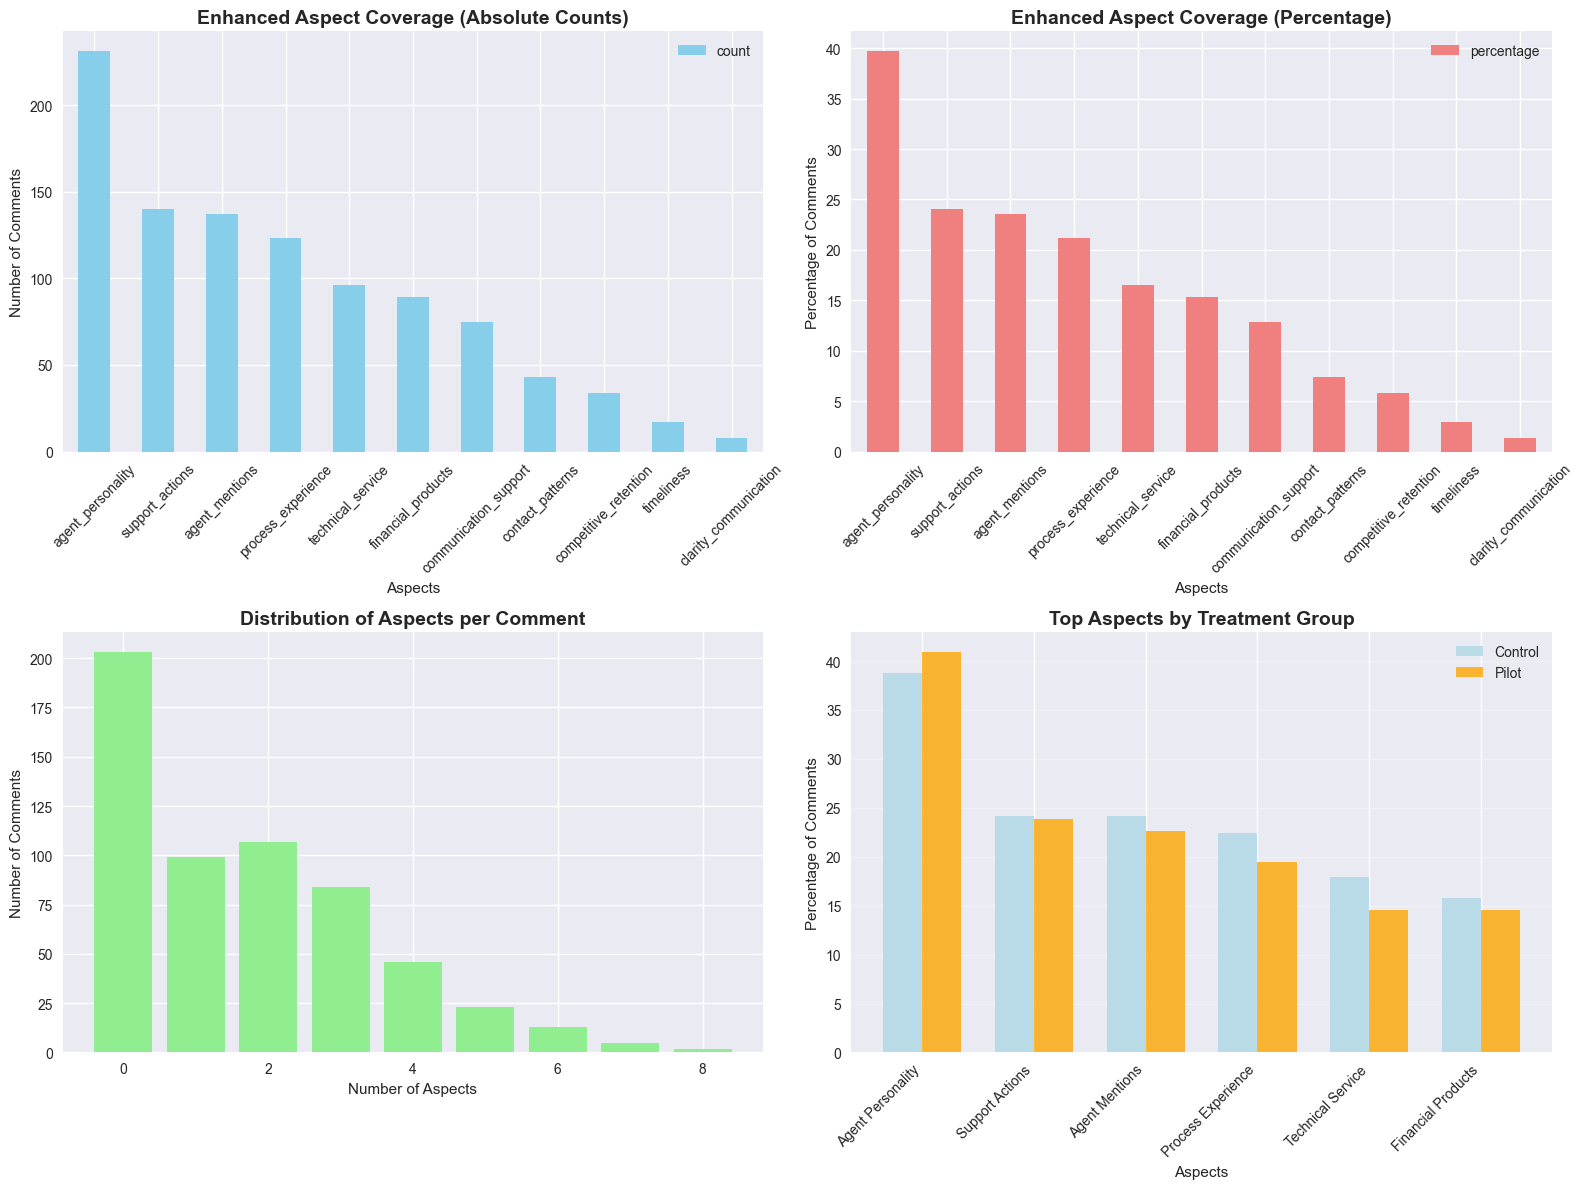

=== Treatment Comparison Results ===


In [265]:
# Create comprehensive visualizations for enhanced aspects
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import chi2_contingency

# Set up the visualization style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# 1. Aspect Coverage Overview
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Coverage bar chart
coverage_df.plot(kind='bar', y='count', ax=ax1, color='skyblue')
ax1.set_title('Enhanced Aspect Coverage (Absolute Counts)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Aspects')
ax1.set_ylabel('Number of Comments')
ax1.tick_params(axis='x', rotation=45)

# Coverage percentage
coverage_df.plot(kind='bar', y='percentage', ax=ax2, color='lightcoral')
ax2.set_title('Enhanced Aspect Coverage (Percentage)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Aspects')
ax2.set_ylabel('Percentage of Comments')
ax2.tick_params(axis='x', rotation=45)

# Number of aspects per comment distribution
aspect_dist = df_enhanced['num_aspects_enhanced'].value_counts().sort_index()
ax3.bar(aspect_dist.index, aspect_dist.values, color='lightgreen')
ax3.set_title('Distribution of Aspects per Comment', fontsize=14, fontweight='bold')
ax3.set_xlabel('Number of Aspects')
ax3.set_ylabel('Number of Comments')

# Treatment comparison for top aspects
top_aspects = coverage_df.head(6).index.tolist()
treatment_comparison = []

for aspect in top_aspects:
    col_name = f'aspect_{aspect}'
    
    # Get counts by treatment
    control_count = df_enhanced[df_enhanced['TREATMENT_BINARY'] == 0][col_name].sum()
    pilot_count = df_enhanced[df_enhanced['TREATMENT_BINARY'] == 1][col_name].sum()
    
    control_total = (df_enhanced['TREATMENT_BINARY'] == 0).sum()
    pilot_total = (df_enhanced['TREATMENT_BINARY'] == 1).sum()
    
    control_pct = (control_count / control_total) * 100
    pilot_pct = (pilot_count / pilot_total) * 100
    
    treatment_comparison.append({
        'aspect': aspect,
        'control_pct': control_pct,
        'pilot_pct': pilot_pct,
        'difference': pilot_pct - control_pct
    })

treatment_df = pd.DataFrame(treatment_comparison)

# Treatment comparison visualization
x_pos = np.arange(len(treatment_df))
width = 0.35

bars1 = ax4.bar(x_pos - width/2, treatment_df['control_pct'], width, 
                label='Control', color='lightblue', alpha=0.8)
bars2 = ax4.bar(x_pos + width/2, treatment_df['pilot_pct'], width, 
                label='Pilot', color='orange', alpha=0.8)

ax4.set_title('Top Aspects by Treatment Group', fontsize=14, fontweight='bold')
ax4.set_xlabel('Aspects')
ax4.set_ylabel('Percentage of Comments')
ax4.set_xticks(x_pos)
ax4.set_xticklabels([asp.replace('_', ' ').title() for asp in treatment_df['aspect']], 
                    rotation=45, ha='right')
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../results/visualizations/topic_modeling/enhanced_aspect_analysis.png', 
            dpi=300, bbox_inches='tight')
plt.show()

print("=== Treatment Comparison Results ===")

In [266]:
# Statistical analysis of treatment effects on enhanced aspects
print("=== Statistical Analysis of Enhanced Aspects ===\n")

significant_aspects = []

for aspect in aspect_keywords.keys():
    col_name = f'aspect_{aspect}'
    
    # Create contingency table
    contingency = pd.crosstab(df_enhanced['TREATMENT_BINARY'], df_enhanced[col_name])
    
    # Perform chi-square test if we have enough observations
    if contingency.min().min() >= 5:  # Standard assumption for chi-square
        chi2, p_val, dof, expected = chi2_contingency(contingency)
        
        # Calculate effect size (Cramér's V)
        n = contingency.sum().sum()
        cramers_v = np.sqrt(chi2 / (n * (min(contingency.shape) - 1)))
        
        # Get percentages
        control_pct = (contingency.loc[0, 1] / contingency.loc[0].sum()) * 100 if 1 in contingency.columns else 0
        pilot_pct = (contingency.loc[1, 1] / contingency.loc[1].sum()) * 100 if 1 in contingency.columns else 0
        difference = pilot_pct - control_pct
        
        print(f"{aspect.replace('_', ' ').title()}:")
        print(f"  Control: {control_pct:.1f}% | Pilot: {pilot_pct:.1f}% | Diff: {difference:+.1f}%")
        print(f"  Chi-square: {chi2:.3f}, p-value: {p_val:.3f}, Cramér's V: {cramers_v:.3f}")
        
        if p_val < 0.05:
            significant_aspects.append({
                'aspect': aspect,
                'p_value': p_val,
                'effect_size': cramers_v,
                'difference': difference,
                'direction': 'Pilot Higher' if difference > 0 else 'Control Higher'
            })
            print(f"  *** SIGNIFICANT at p < 0.05 ***")
        print()

if significant_aspects:
    sig_df = pd.DataFrame(significant_aspects).sort_values('p_value')
    print("=== Significant Treatment Effects ===")
    print(sig_df)
else:
    print("No statistically significant treatment effects found at p < 0.05")

=== Statistical Analysis of Enhanced Aspects ===

Agent Personality:
  Control: 38.8% | Pilot: 40.9% | Diff: +2.1%
  Chi-square: 0.178, p-value: 0.673, Cramér's V: 0.018

Agent Mentions:
  Control: 24.2% | Pilot: 22.7% | Diff: -1.5%
  Chi-square: 0.105, p-value: 0.745, Cramér's V: 0.013

Communication Support:
  Control: 13.1% | Pilot: 12.6% | Diff: -0.6%
  Chi-square: 0.007, p-value: 0.934, Cramér's V: 0.003

Support Actions:
  Control: 24.2% | Pilot: 23.9% | Diff: -0.3%
  Chi-square: 0.000, p-value: 1.000, Cramér's V: 0.000

Process Experience:
  Control: 22.4% | Pilot: 19.4% | Diff: -3.0%
  Chi-square: 0.578, p-value: 0.447, Cramér's V: 0.032

Technical Service:
  Control: 17.9% | Pilot: 14.6% | Diff: -3.3%
  Chi-square: 0.919, p-value: 0.338, Cramér's V: 0.040

Financial Products:
  Control: 15.8% | Pilot: 14.6% | Diff: -1.2%
  Chi-square: 0.088, p-value: 0.767, Cramér's V: 0.012

Competitive Retention:
  Control: 7.5% | Pilot: 3.6% | Diff: -3.8%
  Chi-square: 3.107, p-value: 0.078

=== Robustness Check: Enhanced Aspects vs BERTopic ===

BERTopic Topic Distribution:
substantive_topics
Staff Helpfulness and Communication          75
Professional Service Standards               63
Overall Customer Service Quality             37
Sales Agent Performance and Process          33
Contract Issues and Call Center Problems     33
Service Delivery and Scheduling Issues       29
Phone Support and Account Management         26
Service Speed and Network Coverage           26
Field Engineer Performance                   23
Pricing and Value Proposition                22
Broadband Service and Connectivity           21
Installation Process and Setup Experience    21
Installation Quality and Recommendations     15
Competitor Comparisons (Sky)                 12
Name: count, dtype: int64

=== Coverage Comparison: Enhanced vs BERTopic ===
                  aspect  enhanced_pct  bertopic_pct
0      agent_personality          39.7          18.9
1         agent_mentions          23.5   

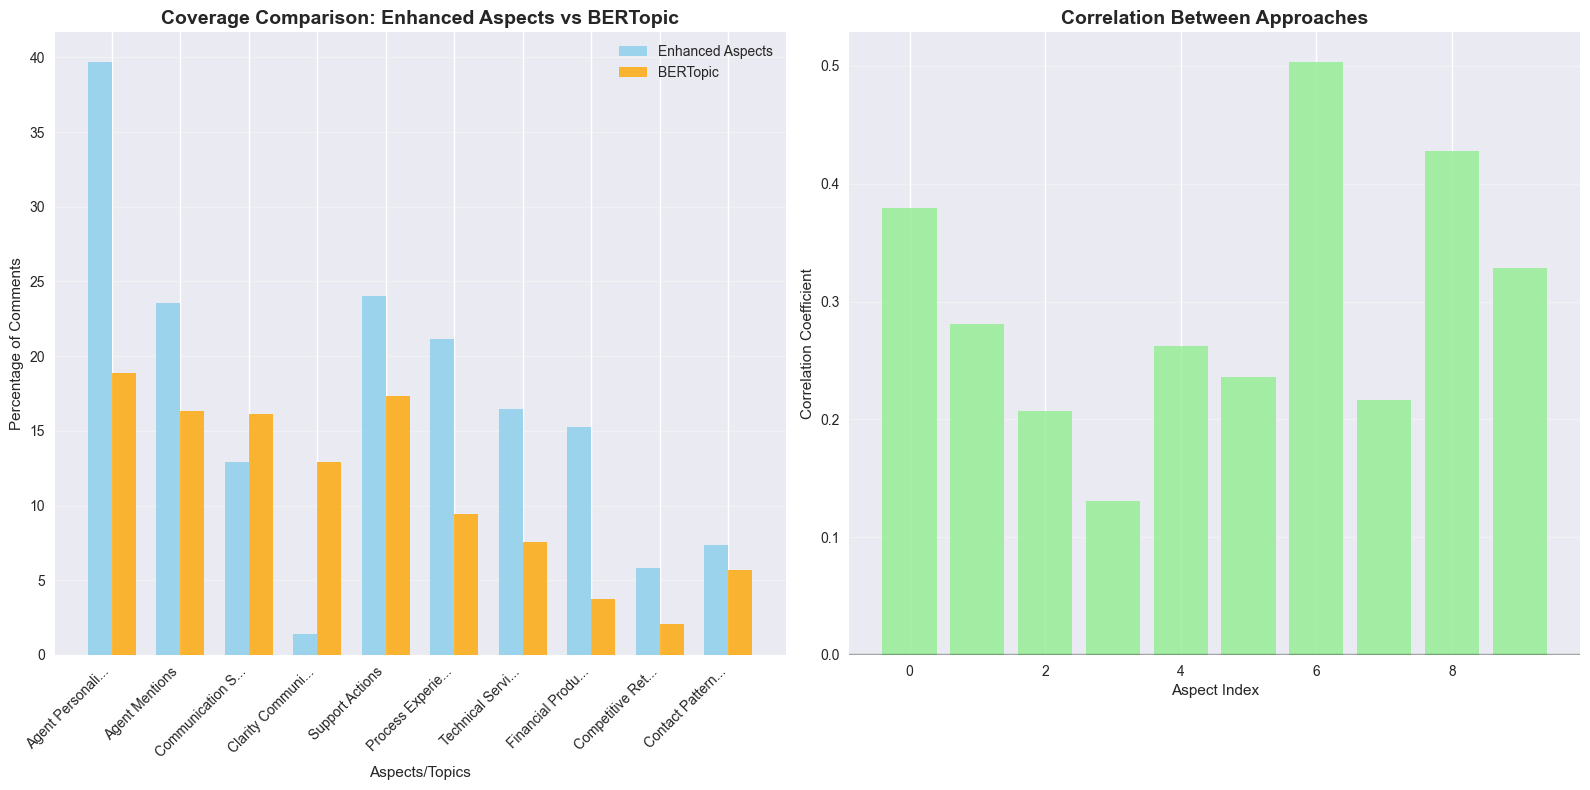


Average correlation between approaches: 0.297
Approaches show moderate agreement


In [268]:
# Robustness comparison: Enhanced Aspects vs BERTopic Results
print("=== Robustness Check: Enhanced Aspects vs BERTopic ===\n")

# Load the original data with BERTopic results for comparison
df_bertopic = pd.read_pickle("../data/processed/data_with_sentiment_and_topics.pkl")

# Create a mapping between our enhanced aspects and BERTopic topics
# First, let's see what topics we have in the BERTopic approach
bertopic_topics = df_bertopic['substantive_topics'].explode().value_counts()
print("BERTopic Topic Distribution:")
print(bertopic_topics)
print()

# Map our enhanced aspects to conceptually similar BERTopic topics
aspect_topic_mapping = {
    'agent_personality': ['Staff Helpfulness and Communication', 'Sales Agent Performance and Process', 'Professional Service Standards'],
    'agent_mentions': ['Staff Helpfulness and Communication', 'Sales Agent Performance and Process'],
    'communication_support': ['Staff Helpfulness and Communication', 'Professional Service Standards'],
    'clarity_communication': ['Staff Helpfulness and Communication'],
    'support_actions': ['Staff Helpfulness and Communication', 'Phone Support and Account Management'],
    'process_experience': ['Service Speed and Network Coverage', 'Service Delivery and Scheduling Issues'],
    'technical_service': ['Broadband Service and Connectivity', 'Field Engineer Performance'],
    'financial_products': ['Pricing and Value Proposition'],
    'competitive_retention': ['Competitor Comparisons (Sky)'],
    'contact_patterns': ['Contract Issues and Call Center Problems']
}

# Compare coverage between approaches
comparison_results = []

for aspect, related_topics in aspect_topic_mapping.items():
    # Enhanced aspect coverage
    aspect_col = f'aspect_{aspect}'
    enhanced_coverage = df_enhanced[aspect_col].sum() if aspect_col in df_enhanced.columns else 0
    enhanced_pct = (enhanced_coverage / len(df_enhanced)) * 100
    
    # BERTopic coverage for related topics
    def check_topic_match(topic_list):
        if isinstance(topic_list, list):
            return any(topic in topic_list for topic in related_topics)
        return False
    
    bertopic_mask = df_bertopic['substantive_topics'].apply(check_topic_match)
    bertopic_coverage = bertopic_mask.sum()
    bertopic_pct = (bertopic_coverage / len(df_bertopic)) * 100
    
    comparison_results.append({
        'aspect': aspect,
        'enhanced_count': enhanced_coverage,
        'enhanced_pct': enhanced_pct,
        'bertopic_count': bertopic_coverage,
        'bertopic_pct': bertopic_pct,
        'related_topics': ', '.join(related_topics)
    })

comparison_df = pd.DataFrame(comparison_results)
print("=== Coverage Comparison: Enhanced vs BERTopic ===")
print(comparison_df[['aspect', 'enhanced_pct', 'bertopic_pct']].round(1))

# Visualize the comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Coverage comparison
aspects_short = [asp.replace('_', ' ').title()[:15] + '...' if len(asp) > 15 
                 else asp.replace('_', ' ').title() for asp in comparison_df['aspect']]

x_pos = np.arange(len(aspects_short))
width = 0.35

bars1 = ax1.bar(x_pos - width/2, comparison_df['enhanced_pct'], width, 
                label='Enhanced Aspects', color='skyblue', alpha=0.8)
bars2 = ax1.bar(x_pos + width/2, comparison_df['bertopic_pct'], width, 
                label='BERTopic', color='orange', alpha=0.8)

ax1.set_title('Coverage Comparison: Enhanced Aspects vs BERTopic', fontsize=14, fontweight='bold')
ax1.set_xlabel('Aspects/Topics')
ax1.set_ylabel('Percentage of Comments')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(aspects_short, rotation=45, ha='right')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Correlation between approaches
correlations = []
for aspect, related_topics in aspect_topic_mapping.items():
    aspect_col = f'aspect_{aspect}'
    if aspect_col in df_enhanced.columns:
        # Create BERTopic equivalent binary
        def check_topic_match_corr(topic_list):
            if isinstance(topic_list, list):
                return 1 if any(topic in topic_list for topic in related_topics) else 0
            return 0
        
        bertopic_binary = df_bertopic['substantive_topics'].apply(check_topic_match_corr)
        
        # Calculate correlation (ensure same length)
        min_len = min(len(df_enhanced), len(bertopic_binary))
        corr = np.corrcoef(df_enhanced[aspect_col][:min_len], bertopic_binary[:min_len])[0,1]
        correlations.append(corr)

ax2.bar(range(len(correlations)), correlations, color='lightgreen', alpha=0.8)
ax2.set_title('Correlation Between Approaches', fontsize=14, fontweight='bold')
ax2.set_xlabel('Aspect Index')
ax2.set_ylabel('Correlation Coefficient')
ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../results/visualizations/topic_modeling/approach_comparison.png', 
            dpi=300, bbox_inches='tight')
plt.show()

print(f"\nAverage correlation between approaches: {np.mean(correlations):.3f}")
print(f"Approaches show {'good' if np.mean(correlations) > 0.3 else 'moderate' if np.mean(correlations) > 0.1 else 'weak'} agreement")

=== VOLT Segment Analysis ===



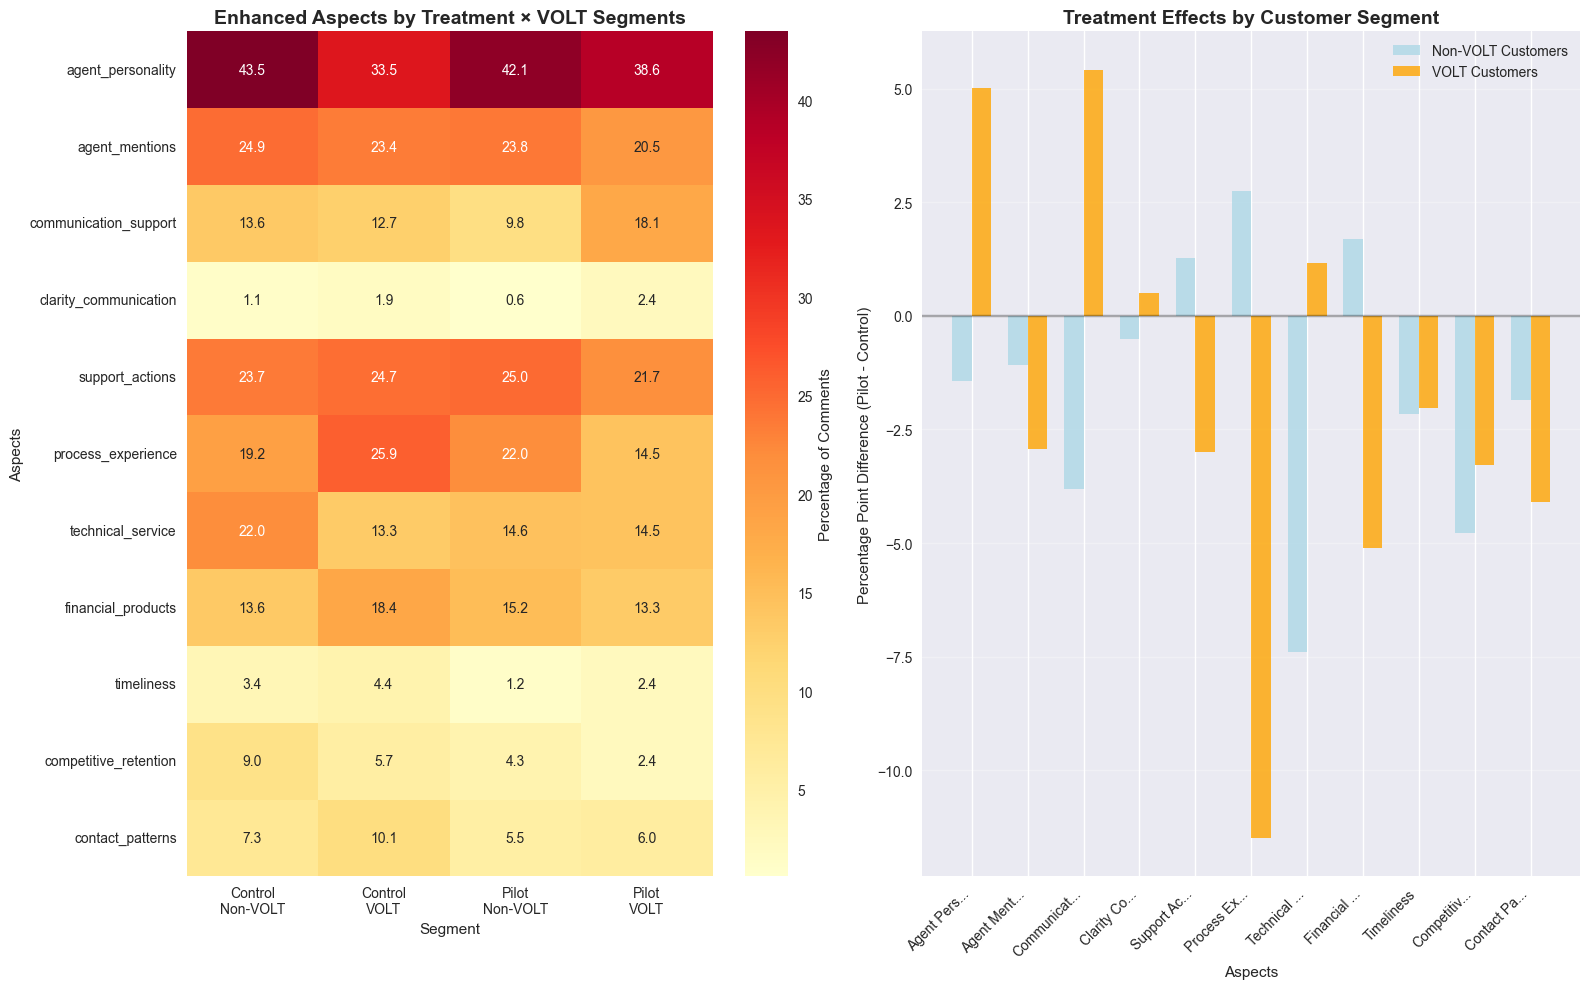

=== Top Treatment Effects by Segment ===
                   aspect  nonvolt_effect  volt_effect  difference
5      process_experience            2.74       -11.49      -14.23
2   communication_support           -3.80         5.41        9.22
6       technical_service           -7.40         1.17        8.57
7      financial_products            1.68        -5.10       -6.79
0       agent_personality           -1.43         5.01        6.44
4         support_actions            1.27        -3.00       -4.27
10       contact_patterns           -1.86        -4.10       -2.25
1          agent_mentions           -1.08        -2.94       -1.86
9   competitive_retention           -4.77        -3.29        1.48
3   clarity_communication           -0.52         0.51        1.03
8              timeliness           -2.17        -2.02        0.15


In [269]:
# VOLT Segment Analysis for Enhanced Aspects
print("=== VOLT Segment Analysis ===\n")

# Analyze how enhanced aspects differ by VOLT status and treatment
volt_analysis = []

for aspect in aspect_keywords.keys():
    col_name = f'aspect_{aspect}'
    if col_name not in df_enhanced.columns:
        continue
    
    # Create 2x2 analysis: VOLT vs Non-VOLT, Control vs Pilot
    segments = {
        'Control_NonVOLT': (df_enhanced['TREATMENT_BINARY'] == 0) & (df_enhanced['VOLT_FLAG_BINARY'] == 0),
        'Control_VOLT': (df_enhanced['TREATMENT_BINARY'] == 0) & (df_enhanced['VOLT_FLAG_BINARY'] == 1),
        'Pilot_NonVOLT': (df_enhanced['TREATMENT_BINARY'] == 1) & (df_enhanced['VOLT_FLAG_BINARY'] == 0),
        'Pilot_VOLT': (df_enhanced['TREATMENT_BINARY'] == 1) & (df_enhanced['VOLT_FLAG_BINARY'] == 1)
    }
    
    segment_stats = {}
    for segment_name, mask in segments.items():
        count = df_enhanced[mask][col_name].sum()
        total = mask.sum()
        pct = (count / total * 100) if total > 0 else 0
        segment_stats[segment_name] = {'count': count, 'total': total, 'percentage': pct}
    
    volt_analysis.append({
        'aspect': aspect,
        **{f'{seg}': stats['percentage'] for seg, stats in segment_stats.items()}
    })

volt_df = pd.DataFrame(volt_analysis)

# Create heatmap for VOLT analysis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 10))

# Prepare data for heatmap
heatmap_data = volt_df.set_index('aspect')[['Control_NonVOLT', 'Control_VOLT', 'Pilot_NonVOLT', 'Pilot_VOLT']]
heatmap_data.columns = ['Control\nNon-VOLT', 'Control\nVOLT', 'Pilot\nNon-VOLT', 'Pilot\nVOLT']

# Create heatmap
sns.heatmap(heatmap_data, annot=True, fmt='.1f', cmap='YlOrRd', 
            cbar_kws={'label': 'Percentage of Comments'}, ax=ax1)
ax1.set_title('Enhanced Aspects by Treatment × VOLT Segments', fontsize=14, fontweight='bold')
ax1.set_xlabel('Segment')
ax1.set_ylabel('Aspects')

# Calculate treatment effects within VOLT segments
treatment_effects_volt = []
treatment_effects_nonvolt = []

for aspect in aspect_keywords.keys():
    col_name = f'aspect_{aspect}'
    if col_name not in df_enhanced.columns:
        continue
    
    # VOLT customers: Pilot vs Control effect
    volt_control = volt_df[volt_df['aspect'] == aspect]['Control_VOLT'].iloc[0]
    volt_pilot = volt_df[volt_df['aspect'] == aspect]['Pilot_VOLT'].iloc[0]
    volt_effect = volt_pilot - volt_control
    treatment_effects_volt.append(volt_effect)
    
    # Non-VOLT customers: Pilot vs Control effect
    nonvolt_control = volt_df[volt_df['aspect'] == aspect]['Control_NonVOLT'].iloc[0]
    nonvolt_pilot = volt_df[volt_df['aspect'] == aspect]['Pilot_NonVOLT'].iloc[0]
    nonvolt_effect = nonvolt_pilot - nonvolt_control
    treatment_effects_nonvolt.append(nonvolt_effect)

# Plot treatment effects by segment
x_pos = np.arange(len(aspect_keywords))
width = 0.35

bars1 = ax2.bar(x_pos - width/2, treatment_effects_nonvolt, width, 
                label='Non-VOLT Customers', color='lightblue', alpha=0.8)
bars2 = ax2.bar(x_pos + width/2, treatment_effects_volt, width, 
                label='VOLT Customers', color='orange', alpha=0.8)

ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)
ax2.set_title('Treatment Effects by Customer Segment', fontsize=14, fontweight='bold')
ax2.set_xlabel('Aspects')
ax2.set_ylabel('Percentage Point Difference (Pilot - Control)')
ax2.set_xticks(x_pos)
ax2.set_xticklabels([asp.replace('_', ' ').title()[:10] + '...' if len(asp) > 10 
                     else asp.replace('_', ' ').title() for asp in aspect_keywords.keys()], 
                    rotation=45, ha='right')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../results/visualizations/customer_segments/volt_aspect_analysis.png', 
            dpi=300, bbox_inches='tight')
plt.show()

# Print top differential effects
print("=== Top Treatment Effects by Segment ===")
aspect_names = list(aspect_keywords.keys())
effects_comparison = pd.DataFrame({
    'aspect': aspect_names,
    'nonvolt_effect': treatment_effects_nonvolt,
    'volt_effect': treatment_effects_volt,
    'difference': np.array(treatment_effects_volt) - np.array(treatment_effects_nonvolt)
})

effects_comparison = effects_comparison.reindex(effects_comparison['difference'].abs().sort_values(ascending=False).index)
print(effects_comparison.round(2))

In [270]:
# Merge Enhanced Aspects into Final Dataset
print("=== Merging Enhanced Aspects into Final Dataset ===")

# Load the complete dataset with BERTopic results
df_final = pd.read_pickle("../data/processed/data_with_sentiment_and_topics.pkl")

# Add enhanced aspect columns
aspect_cols_to_add = [col for col in df_enhanced.columns if col.startswith('aspect_')]
aspect_cols_to_add.extend(['aspects_enhanced', 'num_aspects_enhanced'])

# Merge on index (they should have the same structure)
for col in aspect_cols_to_add:
    if col in df_enhanced.columns:
        df_final[col] = df_enhanced[col]

print(f"Final dataset shape: {df_final.shape}")
print(f"Added {len(aspect_cols_to_add)} enhanced aspect columns")

# Save the comprehensive dataset
df_final.to_pickle("../data/processed/data_with_sentiment_topics_and_aspects.pkl")
df_final.to_csv("../data/processed/data_with_sentiment_topics_and_aspects.csv", index=False)

print("✅ Comprehensive dataset saved!")

# Create a summary comparison table for the presentation
print("\n=== Summary for Presentation ===")

approach_summary = {
    'Approach': ['BERTopic (Unsupervised)', 'Enhanced Aspects (Rule-based)', 'Combined'],
    'Number of Categories': [
        len(df_final['substantive_topics'].explode().unique()) - 1,  # -1 for empty lists
        len(aspect_keywords),
        len(df_final['substantive_topics'].explode().unique()) - 1 + len(aspect_keywords)
    ],
    'Average Categories per Comment': [
        df_final['num_topics_assigned'].mean(),
        df_final['num_aspects_enhanced'].mean(),
        (df_final['num_topics_assigned'] + df_final['num_aspects_enhanced']).mean()
    ],
    'Coverage (% of comments)': [
        (df_final['num_topics_assigned'] > 0).mean() * 100,
        (df_final['num_aspects_enhanced'] > 0).mean() * 100,
        ((df_final['num_topics_assigned'] > 0) | (df_final['num_aspects_enhanced'] > 0)).mean() * 100
    ]
}

summary_df = pd.DataFrame(approach_summary)
print(summary_df.round(2))

# Save summary for results
summary_df.to_csv("../results/topic_modeling_approach_summary.csv", index=False)

print(f"\n📊 All visualizations saved to: ../results/visualizations/")
print(f"📈 Key files for presentation:")
print(f"   - Enhanced aspect analysis: topic_modeling/enhanced_aspect_analysis.png")
print(f"   - Approach comparison: topic_modeling/approach_comparison.png") 
print(f"   - VOLT segment analysis: customer_segments/volt_aspect_analysis.png")
print(f"   - Summary table: topic_modeling_approach_summary.csv")

=== Merging Enhanced Aspects into Final Dataset ===
Final dataset shape: (582, 34)
Added 13 enhanced aspect columns
✅ Comprehensive dataset saved!

=== Summary for Presentation ===
                        Approach  Number of Categories  Average Categories per Comment  Coverage (% of comments)
0        BERTopic (Unsupervised)                    14                            0.75                     56.36
1  Enhanced Aspects (Rule-based)                    11                            1.71                     65.12
2                       Combined                    25                            2.46                     69.07

📊 All visualizations saved to: ../results/visualizations/
📈 Key files for presentation:
   - Enhanced aspect analysis: topic_modeling/enhanced_aspect_analysis.png
   - Approach comparison: topic_modeling/approach_comparison.png
   - VOLT segment analysis: customer_segments/volt_aspect_analysis.png
   - Summary table: topic_modeling_approach_summary.csv
